# Imports

In [98]:
import numpy as np
import fitsio
import time
import pandas as pd
import matplotlib.pyplot as plt
from iminuit import Minuit
from scipy.optimize import minimize
from scipy.optimize import least_squares
from iminuit.cost import LeastSquares
from scipy.optimize import fsolve
from scipy.interpolate import CubicSpline
from astropy.io import fits
from scipy.optimize import curve_fit
from scipy.interpolate import interp1d
from scipy.interpolate import InterpolatedUnivariateSpline
from scipy.stats import binned_statistic 

# Colorblind friendly colors
CB_color_cycle = ['#377eb8', '#ff7f00', '#4daf4a',
                  '#f781bf', '#a65628', '#984ea3',
                  '#999999', '#e41a1c', '#dede00', 
                  '#000000', '#FFFFFF']

%matplotlib inline

# select a target redshift
target_redshift = 2.8
safe_z = str(target_redshift).replace('.', '-')


In [3]:


# path = f'/pscratch/sd/m/mherbold/tests/P1D_Mocks/CF/test{safe_z}_xiG_full_output.txt'
# data = np.loadtxt(path)
# full_v = data[:, 0]
# full_xiG = data[:, 1]
# full_v_spacing = full_v[1] - full_v[0]
# N = len(full_xiG)
# L = N * full_v_spacing

# # FFT to power
# fft_xiG = np.fft.rfft(full_xiG)
# power = full_v_spacing * fft_xiG

# # Compute corresponding k values
# karr = 2 * np.pi * np.fft.rfftfreq(N, d=full_v_spacing)

# # Take only the real part of the power spectrum
# # power_real = power.real  # Or use np.abs(power) if you're interested in magnitude
# power_real = np.abs(power)
# power_real2 = power.real

# plt.loglog(karr, power_real, label='abs(val)', alpha=0.7)
# plt.loglog(karr, power_real2, label='.real', alpha=0.7)
# plt.legend()
# plt.ylim(10e-6)
# plt.show()


# path3 = f'/pscratch/sd/m/mherbold/tests/P1D_Mocks/P_G/P_G-{safe_z}.txt'
# path2 = f'/pscratch/sd/m/mherbold/tests/P1D_Mocks/P_G/test_P_G-{safe_z}.txt'
# data2 = np.loadtxt(path2)
# data3 = np.loadtxt(path3)
# k_array = data2[:, 0]
# p1d_array = data2[:, 1]
# k_array3 = data3[:, 0]
# p1d_array3 = data3[:, 1]

# plt.loglog(k_array, p1d_array, label='file, new', alpha=0.5)
# plt.loglog(k_array3, p1d_array3, label='file, old', alpha=0.5)
# # plt.loglog(karr, power_real, label='new test', alpha=0.5)
# plt.legend()
# plt.show()

In [4]:
# cf_fullpath = f'/pscratch/sd/m/mherbold/tests/P1D_Mocks/CF/test{safe_z}_xiG_full_output.txt'
# data_full = np.loadtxt(cf_fullpath)
# full_v = data_full[:, 0]
# full_xiG = data_full[:, 1]

# cf_fullpath_old = f'/pscratch/sd/m/mherbold/tests/P1D_Mocks/CF/{safe_z}_xiG_full_output.txt'
# data_full_old = np.loadtxt(cf_fullpath_old)
# full_v_old = data_full_old[:, 0]
# full_xiG_old = data_full_old[:, 1]

# plt.plot(full_v, full_xiG, label='new')
# plt.plot(full_v_old, full_xiG_old, label='old')
# plt.legend(loc='upper center')

# Mean flux

Mean Flux from Turner et al. (2024): https://arxiv.org/html/2405.06743v2

$$ \tau(z) = \tau_0 (1+z)^{\gamma} $$

where, 

$ \tau_0 = 0.00246 \pm 0.14 $ and $ \gamma = 3.62 \pm 0.04 $,

and mean flux is, $\bar{F}(z) = e^{-\tau(z)}$

In [5]:
# Mean flux from Turner et al. (2024)

def turner24_mf(z):
    tau_0 = -2.46e-3
    gamma = 3.62
    return np.exp(tau_0 * (1 + z)**gamma)

DESI EDR parameters, PD13 pivot points (k,z), and fiducial / target P1D are defined at: 
https://github.com/p-slash/qsotools/blob/c58549f41fb2bd56a59c4b4362d8b331334ce13a/py/qsotools/fiducial.py#L42

And PD 13 reffers to: https://arxiv.org/abs/1306.5896

In [7]:
# DESI EDR Parameters

DESI_EDR_PARAMETERS = (
    7.63089e-02, -2.52054e+00, -1.27968e-01,
    3.67469e+00, 2.85951e-01, 7.33473e+02)

# set pivot points for k and z using fiducial power estimate
PD13_PIVOT_K = 0.009 # note: k_0
PD13_PIVOT_Z = 3.0   # note: z0 = 3

Naim_2020_parameters = (
    0.066, -2.685, -0.22,
    3.59, -0.18, 0.53)


Baseline power spectrum estimate modifies fitting function from PD13 (eq. 14), with best fitting parameters (A, n, $\alpha$, B, $\beta$, $k_1$(km/s)), with a Lorentzian decay: 

$$ \frac{k P(k,z)}{\pi} = A \frac{(k/k_0)^{3 + n + \alpha \ln k/k_0}}{1 + (k / k_1)^2} \left(\frac{1+z}{1+z_0}\right)^{B + \beta \ln k/k_0} $$

where $k_0 = 0.009$ km/s and $z_0 = 3.0$. 

**Table 1.** Top:PD13 BOSS likelihood fitting parameters. Bottom: Karacaylı et al. 2020 (eq. 17), DESI Lite, not EDR

| A  | n | $\alpha$ | B | $\beta$ | $k_1$(km/s) |
| ---|---|  ---     |---|---      |---          |
| 0.06 |-2.55|  -.010     |3.55|-0.28      | -  |
| 0.066|-2.685|  -0.22     |3.59|-0.18      |0.53|

In [8]:
# Define target P1D
# note: lmd = k1, PD13_PIVOT_K = k0, PD13_PIVOT_Z = z0

def evaluatePD13Lorentz(X, A, n, alpha, B, beta, lmd):
    k, z = X
    q0 = k / PD13_PIVOT_K + 1e-10

    result = (A * np.pi / PD13_PIVOT_K) * np.power(
        q0, 2. + n + alpha * np.log(q0)) / (1. + lmd * k**2)

    if z is not None:
        x0 = (1. + z) / (1. + PD13_PIVOT_Z)
        result *= np.power(q0, beta * np.log(x0)) * np.power(x0, B)

    return result


# Define Lognormal Transforms and Functions

Redshift evolution: 

$$a^2(z) =  \left( \frac{1+z}{1+z_0} \right) ^{-\nu} $$

where, $z_0 = 3$, and $\nu = 2.82$, such that: 

$$a(z) =  \left( \frac{1+z}{1+z_0} \right) ^{-\nu / 2} $$


In [9]:
def a2_z(zp, nu=2.82, z0=3.0):
    return np.power((1. + zp) / (1.+z0), -nu)

def a_z(zp, nu=2.82, z0=3.0):
    return np.sqrt(np.power((1. + zp) / (1.+z0), -nu))

Optical Depth: 

$$ \tau(z) = \tau_0 \left( \frac{1+z}{1+z_0} \right)^{\tau_1} $$

where, $z_0 = 3$, $\tau_0 = 0.55$, and $\tau_1 = 5.1$

In [10]:
def t_of_z(zp, tau0=0.55, tau1=5.1, z0=3.):
    return tau0 * np.power((1. + zp) / (1.+z0), tau1)

Lognormal Transform: 

$$ n(z) = e^{2 \delta(z) - \sigma^2} $$

In [11]:
def n_z(zp, nu, sigma2, z0=3):
    return np.exp(-a2_z(zp, nu, z0) - sigma2)

Apply to optical depth: 

$$ x(z) \rightarrow \tau(z) * n(z) $$


$$ x(z) = \tau_0 \left( \frac{1+z}{1+z_0} \right)^{\tau_1} * e^{2 \delta(z) - \sigma^2} $$

In [12]:
def x_of_z(zp, tau0, tau1, nu, sigma2, z0=3):
    return t_of_z(zp, tau0, tau1, z0) * np.exp(-a2_z(zp, nu, z0) * sigma2)

Flux: 

$$ F(z) = e^{-\tau(z)}  $$

$$ F(z) \rightarrow e^{ -\tau(z) * n(z) } \rightarrow e^{-x(z)}$$

such that:

$$ F(z) = exp\left[- \tau_0 \left( \frac{1+z}{1+z_0} \right)^{\tau_1} * e^{2 \left( \frac{1+z}{1+z_0} \right)^{-\nu / 2} \delta(v)} * e^{- \left( \frac{1+z}{1+z_0} \right)^{-\nu} \sigma^2}\right] $$

where, $\delta(v) \approx \sqrt{2 \sigma^2} * \delta_g$, to simulate FT on gaussian grid. 

In [13]:
# note: for mock generation code, need to use \delta (v), not \delta (g)
# the sqrt{2 sigma^2} is to simulate the FFT on gaussian grid

def Flux_d_z(delta_g, z, tau0, tau1, nu, sigma2, z0=3):
    e1 = np.exp(2 * a2_z(z, nu / 2, z0) * np.sqrt(2 * sigma2) * delta_g)
    e2 = x_of_z(z, tau0, tau1, nu, sigma2, z0)
    return np.exp(-e2 * e1)

Mean Flux, using Gaussian-Hermite Quadrature:

In [14]:
# def Gauss-Hermite quadrature points and weights
degree = 25

gausshermite_xi_deg, gausshermite_wi_deg = np.polynomial.hermite.hermgauss(degree)

def lognMeanFluxGH(z, tau0, tau1, nu, sigma2, degree = degree, z0=3):
    gausshermite_xi, gausshermite_wi = np.polynomial.hermite.hermgauss(degree)

    XIXI, ZZ = np.meshgrid(gausshermite_xi, z)

    Y = Flux_d_z(XIXI, ZZ, tau0, tau1, nu, sigma2, z0)
    result = np.dot(Y, gausshermite_wi)

    return result / np.sqrt(np.pi)
    

Input Gaussian Power: 

$$ P(k) = \frac{\exp [ n * q_0 - \alpha q_0^2 ]}{1 + (k/k_1)^{\gamma}} * \exp \left[ -\frac{(k/0.2)^2}{2} \right] $$

where, $q_0 = \ln \left(\frac{k}{0.001}+10^{-15}\right)$, $n = 0.5$, $\gamma = 1.8$, $k_1 = 0.04$

In [15]:
def lognGeneratingPower(k, n=0.5, alpha=0.26, gamma=1.8, k1=0.04):
    q0 = np.log(k / 0.001 + 1e-15)
    return np.exp(n * q0 - alpha * q0**2) / (1. + (k / k1)**gamma) * np.exp(-(k / 0.2)**2 / 2)

In [17]:
# Calculate meshgrid for Gauss-Hermite once
YY1, YY2 = np.meshgrid(gausshermite_xi_deg, gausshermite_xi_deg, indexing='ij')
WW1, WW2 = np.meshgrid(gausshermite_wi_deg, gausshermite_wi_deg, indexing='ij')

# Fit for mean flux

In [18]:
# create redshift array
z_array = np.linspace(1.8, 5.0, 500)

# choose precision
precision = 1e-5

# def model and error / precision
F_turner = turner24_mf(z_array)
Err_turner = F_turner * precision + 1e-8

Define a cost funciton: 

$$ d = \frac{\bar{F}_{model}-\bar{F}_{measured}}{Error_{model}} $$

and, $cost = d \cdot d$ 

In [20]:
# def cost function for 4 parameters
def cost(tau0, tau1, nu, sigma2):
    d = (F_turner - lognMeanFluxGH(z_array, tau0, tau1, nu, sigma2, z0=3)) / Err_turner
    return d.dot(d)

# Set initial guesses for fitting parameters
tau0, tau1, nu, sigma2 = 0.55, 5.1, 2.82, 1.0
# tau0, tau1, nu = 0.55, 5.1, 2.82

# minimizer: minimizes cost and determines best fit values for parameters
mini = Minuit(cost, tau0, tau1, nu, sigma2)

  # Optional: Set bounds on sigma2
# mini.limits['sigma2'] = (1.0, 3.0)
# optional: fix sigma2
# mini.fixed['sigma2'] = True

mini.errordef = Minuit.LEAST_SQUARES
mini.migrad()


┌─────────────────────────────────────────────────────────────────────────┐
│                                Migrad                                   │
├──────────────────────────────────┬──────────────────────────────────────┤
│ FCN = 9.659e+05                  │              Nfcn = 376              │
│ EDM = 2.13e-08 (Goal: 0.0002)    │            time = 0.9 sec            │
├──────────────────────────────────┼──────────────────────────────────────┤
│          Valid Minimum           │   Below EDM threshold (goal x 10)    │
├──────────────────────────────────┼──────────────────────────────────────┤
│      No parameters at limit      │           Below call limit           │
├──────────────────────────────────┼──────────────────────────────────────┤
│             Hesse ok             │         Covariance accurate          │
└──────────────────────────────────┴──────────────────────────────────────┘
┌───┬────────┬───────────┬───────────┬────────────┬────────────┬─────────┬─────────┬───────┐
│   │ Name   │   Value   │ Hesse Err │ Minos Err- │ Minos Err+ │ Limit-  │ Limit+  │ Fixed │
├───┼────────┼───────────┼───────────┼────────────┼────────────┼─────────┼─────────┼───────┤
│ 0 │ tau0   │ 673.77e-3 │  0.06e-3  │            │            │         │         │       │
│ 1 │ tau1   │  5.31008  │  0.00016  │            │            │         │         │       │
│ 2 │ nu     │  2.16175  │  0.00017  │            │            │         │         │       │
│ 3 │ sigma2 │  1.50381  │  0.00014  │            │            │         │         │       │
└───┴────────┴───────────┴───────────┴────────────┴────────────┴─────────┴─────────┴───────┘
┌────────┬─────────────────────────────────────────┐
│        │      tau0      tau1        nu    sigma2 │
├────────┼─────────────────────────────────────────┤
│   tau0 │  3.64e-09     -6e-9      8e-9      9e-9 │
│   tau1 │     -6e-9  2.61e-08 -0.027e-6 -0.015e-6 │
│     nu │      8e-9 -0.027e-6  2.91e-08  0.019e-6 │
│ sigma2 │      9e-9 -0.015e-6  0.019e-6  2.01e-08 │
└────────┴─────────────────────────────────────────┘

In [21]:
# # Optional: Open a file for writing the data
# with open('flux_data.txt', 'w') as f:
#     # Loop through each value in z_array and F_turner
#     for z, flux in zip(z_array, F_turner):
#         # Write the z and flux values in two columns
#         # f.write(f"{z}  {flux+(0.5**z)}\n")
#         f.write(f"{z}  {flux}\n")

# print("Data exported successfully!")

Note: we do not expect .mean() to line up at every redshift, just with the current redshift 

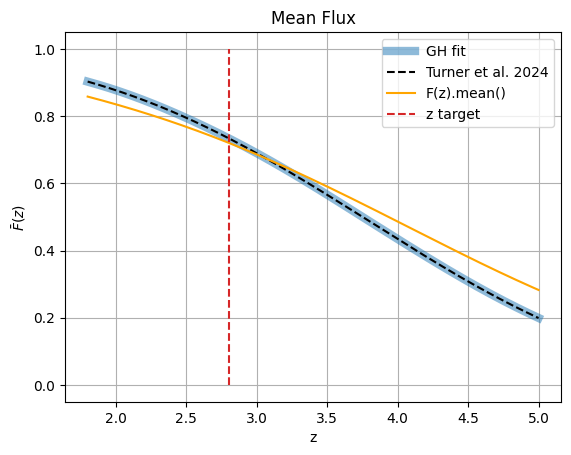

In [24]:
z_list = 1.8, 2.0, 2.2, 2.4, 2.6, 2.8, 3.0, 3.2, 3.4, 3.6, 3.8, 4.0, 4.2, 4.4, 4.6, 4.8, 5.0
gaussian_random_field = np.random.default_rng(10).normal(size=500)

def basic_flux_mean(z):
    mean_flux = np.average(Flux_d_z(gaussian_random_field, z, *mini.values, z0=3))
    return(mean_flux)
    
flux_test = []
turner24_list = []
percent_diff_flux_model = []

for i in z_array:
    flux_test.append(basic_flux_mean(i))
    turner24_list.append(turner24_mf(i))
    percent_diff_flux_model.append(100* ((basic_flux_mean(i) - turner24_mf(i)) / turner24_mf(i)))


plt.plot(z_array, lognMeanFluxGH(z_array, *mini.values), 
         color='tab:blue', ls='-', label='GH fit', lw='6', alpha = 0.5)
plt.plot(z_array, F_turner, color='black', ls='--', 
         label='Turner et al. 2024')
plt.plot(z_array, flux_test, color='orange', label='F(z).mean()')
plt.vlines(target_redshift, ymin=0,ymax=1, ls='--', color='tab:red', label='z target')

plt.title('Mean Flux')
plt.xlabel('z')
plt.ylabel(r'$\bar F(z) $')
plt.legend()
plt.grid(True)
plt.show()

# Fit for Correlation Function

In [27]:
def lognXiFfromXiG_pointwise(z, xi_gauss, tau0, tau1, nu, sigma2, z0=3):
    """
    Arguments
    ---------
    z: float
        Single redshift
    tau0, tau1: float
        Amplitude (tau0) and power (tau1) of optical depth
    nu: float
        Slope of growth (a(z) -> D(z))
    xi_gauss: float
        Single xi_g value from Gaussian random field
    """
    # sigma2 = xi_gauss[0]
    # sigma2 = 1.50381
    xi_sine = np.clip(xi_gauss / sigma2, -1, 1)
    xi_cosine = np.sqrt(1 - xi_sine**2)
    XI_VEC = np.array([xi_sine, xi_cosine])

    YY2_XI_VEC_WEIGHTED = np.dot(XI_VEC, np.array([YY1, YY2]).transpose(1, 0, 2))

    # Redshift-dependent computations
    mean_flux_z = lognMeanFluxGH(z, tau0, tau1, nu, sigma2, z0)
    sigmaz = a2_z(z, nu / 2, z0) * np.sqrt(sigma2)
    tempxz = x_of_z(z, tau0, tau1, nu, sigma2, z0)
    delta1 = YY1 * sigmaz * 2 * np.sqrt(2)
    delta2 = YY2_XI_VEC_WEIGHTED * sigmaz * 2 * np.sqrt(2)

    F1 = np.exp(-tempxz * np.exp(delta1))
    F2 = np.exp(-tempxz * np.exp(delta2))
    D1 = F1 / mean_flux_z - 1
    D2 = F2 / mean_flux_z - 1
    tempfunc = WW1 * WW2 * D1 * D2

    # Return a single xi_f scalar
    xi_f = np.sum(tempfunc) / np.pi

    return xi_f

# test: should return a single number
lognXiFfromXiG_pointwise(2.8, 0.8, *mini.values, z0=3)

np.float64(0.0863959695251481)

In [37]:
# create velocity array 
numvpoints = 2**20
dv = 1.0 # (km/s) 
v_array = np.arange(numvpoints) * dv
k_arr  = 2. * np.pi * np.fft.rfftfreq((2 * numvpoints)-1, d=dv) + 1e-12 

# DESI EDR range
zlist = np.array([2.0, 2.2, 2.4, 2.6, 2.8, 3.0, 3.2, 3.4, 3.6, 3.8])

# extended
# zlist = np.array([2.0, 2.2, 2.4, 2.6, 2.8, 3.0, 3.2, 3.4, 3.6, 3.8, 4.0, 4.2, 4.4, 4.6, 4.8, 5.0])


Baseline power spectrum estimate modifies fitting function from PD13 (eq. 14), with best fitting parameters (A, n, $\alpha$, B, $\beta$, $k_1$(km/s)), with a Lorentzian decay: 

$$ \frac{k P(k,z)}{\pi} = A \frac{(k/k_0)^{3 + n + \alpha \ln k/k_0}}{1 + (k / k_1)^2} \left(\frac{1+z}{1+z_0}\right)^{B + \beta \ln k/k_0} $$

where $k_0 = 0.009$ km/s and $z_0 = 3.0$. 

**Table 1.** Top to bottom: 

PD13 BOSS,  
Karacaylı et al. 2020 DESI lite,  
Karacaylı et al. 2023 DESI EDR,  
Karacaylı et al. 2025 DESI Y1
<!-- Top: PD13 BOSS likelihood fitting parameters. 
<!-- Bottom: Karacaylı et al. 2020 (eq. 17), DESI Lite, not EDR -->

| A  | n | $\alpha$ | B | $\beta$ | $k_1$(km/s) |
|---    |---   |  ---    |--- |---    |---   |
| 0.06  |-2.55 |  -.010  |3.55|-0.28  | -    |
| 0.066 |-2.685|  -0.22  |3.59|-0.18  |0.53  |
| 0.066 |-2.685|  -0.22  |3.59|-0.16  |0.053 |
| 0.0763|-2.52 |  -0.128 |3.67|-0.286 |0.0369|

In [38]:
# fit P1D of DESI EDR
# Start with an empty array the size / shape of k and z arrays
p1d_edr_fit = np.empty((zlist.size, k_arr.size))

# Evaluate P1D for each (k,z), using DESI EDR Param. def. above
for i, z in enumerate(zlist):
    p1d_edr_fit[i] = evaluatePD13Lorentz((k_arr, z), *DESI_EDR_PARAMETERS)

In [39]:
def compute_velocity_grid_properties(k_array):
    """
    Compute velocity grid properties from an input k_array.

    Parameters:
        k_array (numpy array): Array of wavenumbers (h/Mpc)

    Returns:
        dv (float): Velocity spacing
        numvpoints (int): Number of velocity points
    """
    numvpoints = len(k_array)  # Number of points in k-array
    
    if numvpoints < 2:
        raise ValueError("k_array must have at least two points to determine spacing.")

    # Determine dv correctly
    k_min, k_max = np.min(k_array), np.max(k_array)
    
    # Check if k-array is uniformly spaced
    dk_values = np.diff(k_array)
    if np.allclose(dk_values, dk_values[0]):  # If k is evenly spaced
        dk = dk_values[0]
        dv = np.pi / (dk * numvpoints)  # Corrected factor of 2
    else:
        # More general case: Use range of k values
        dv = np.pi / ((k_max - k_min) / (numvpoints - 1))

    return dv, numvpoints

# Example usage
dv, numvpoints = compute_velocity_grid_properties(k_arr)

print(f"dv (velocity spacing) = {dv:.5f}")
print(f"numvpoints (number of velocity points) = {numvpoints}")


dv (velocity spacing) = 1.00000
numvpoints (number of velocity points) = 1048576


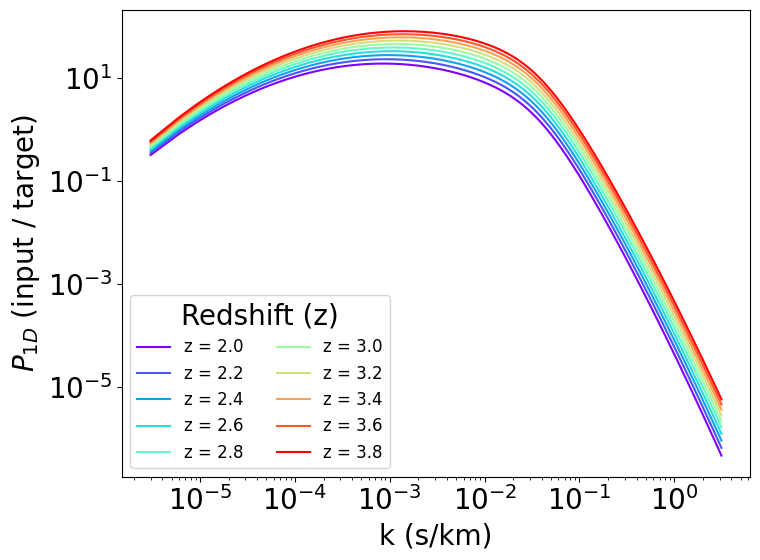

In [40]:
plt.figure(figsize=(8, 6))
plt.rcParams.update({'font.size': 20})

cmap = plt.cm.rainbow  # You can use 'viridis', 'plasma', or other color schemes
norm = plt.Normalize(vmin=min(zlist), vmax=max(zlist))  # Normalize to the range of z_list

for z, xi in zip(zlist, p1d_edr_fit):
    color = cmap(norm(z))                                             # Get the corresponding color from the colormap
    plt.loglog(k_arr[1:], xi[1:], label=f"z = {z:.1f}", color=color)  # Format z to one decimal place

# Set up the legend and plot adjustments
plt.legend(loc='lower left', ncol=2, title="Redshift (z)", fontsize=12)
plt.xlabel('k (s/km)')
plt.ylabel(r'$P_{1D}$ (input / target)')
plt.tight_layout()
plt.show()

Get the correlation function from input power model estimates:

In [42]:
xif_edr_fit = np.empty((zlist.size, numvpoints)) 

for i, z in enumerate(zlist):
    xif_edr_fit[i] = (np.fft.irfft(p1d_edr_fit[i]))[:numvpoints] / dv


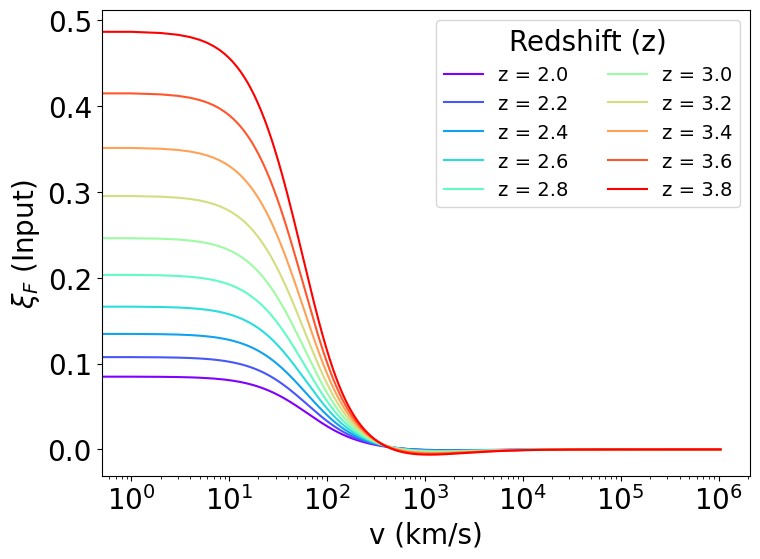

In [43]:
plt.figure(figsize=(8, 6))
plt.rcParams.update({'font.size': 20})

# Choose a colormap (e.g., 'viridis', 'plasma', etc.)
cmap = plt.cm.rainbow  # You can use 'viridis', 'plasma', or other color schemes
norm = plt.Normalize(vmin=min(zlist), vmax=max(zlist))  # Normalize to the range of z_list

#################################################

# Plot the correlation function (F) for each z value
for z, xi in zip(zlist, xif_edr_fit):
    color = cmap(norm(z))  # Get the corresponding color from the colormap
    plt.semilogx(v_array, xi, label=f"z = {z:.1f}", color=color)  # Format z to one decimal place

# Set up the legend and plot adjustments
plt.legend(loc='upper right', ncol=2, title="Redshift (z)", fontsize=14)
plt.xlabel('v (km/s)')
plt.ylabel(r'$\xi_F$ (Input)')
# plt.title(r'$\xi_F$ EDR')
plt.tight_layout()
plt.show()


In [44]:
# Set parameters for optimization
redshift_index = np.where(zlist == target_redshift)[0][0]
xi_f_target = xif_edr_fit[redshift_index]  
# xi_f target is just the xi_f EDR fit at a given redshift (e.g. 2.8)

print("redshift = " +str(zlist[redshift_index]))

redshift = 2.8


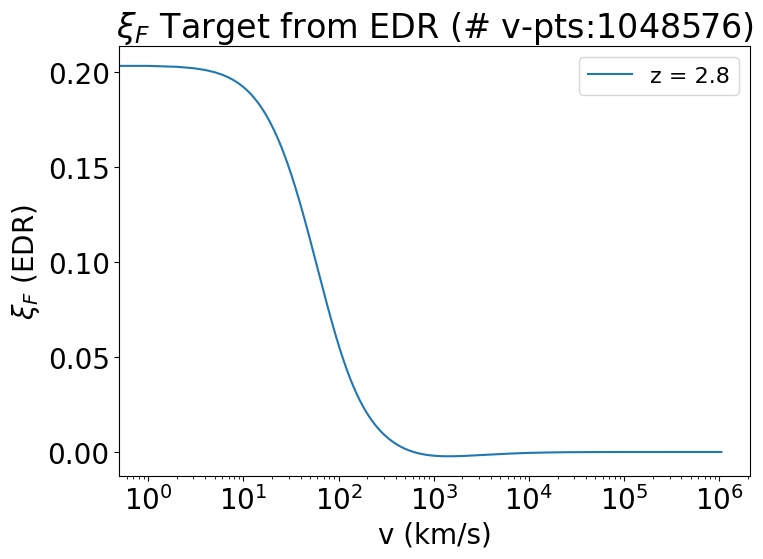

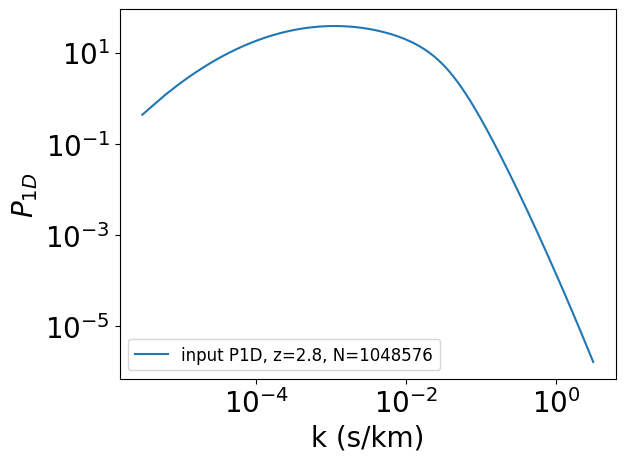

In [45]:
plt.figure(figsize=(8, 6))
plt.rcParams.update({'font.size': 20})

plt.semilogx(v_array, xif_edr_fit[redshift_index], label='z = '+str(zlist[redshift_index]))
plt.xlabel('v (km/s)')
plt.ylabel(r'$\xi_F$ (EDR)')
plt.title(r'$\xi_F$ Target from EDR (# v-pts:'+str(numvpoints)+')')
plt.legend(fontsize=16)
plt.tight_layout()
plt.show()
# plt.savefig('EDR_Correlation_Function_single_redshift')

# note: this is what we are trying to fit, by finding the optimal xi_g that gives 
#       the corresponding xi_f here 


plt.loglog(k_arr[1:], p1d_edr_fit[redshift_index][1:], label = 'input P1D, z='+str(zlist[redshift_index])+', N='+str(numvpoints))
plt.legend(fontsize=12)
plt.xlabel('k (s/km)')
plt.ylabel(r'$P_{1D}$ ')
plt.show()


In [46]:

# liner interpolation of input power

# input arrays, selected above
p1d_input = p1d_edr_fit[redshift_index][1:]
k_array_input = k_arr[1:]

# Define the new number of points (e.g., 2^20)
new_size = 2**20
new_v_array = np.arange(new_size) * dv

# Generate the new k_array with finer spacing
k_array_fine = np.linspace(k_array_input.min(), k_array_input.max(), new_size)

# Perform cubic spline interpolation
cs = CubicSpline(k_array_input, p1d_input)

# Evaluate at new k_array points
p1d_fine = cs(k_array_fine)

# Output: p1d_fine and k_array_fine now have the desired resolution
print("New shape of interpolated data:", p1d_fine.shape)  # Should be (2^20,)

plt.loglog(k_arr[1:], p1d_edr_fit[redshift_index][1:], label = 'input P1D, z='+str(zlist[redshift_index])+', N='+str(numvpoints), alpha=0.7)
plt.loglog(k_array_fine, p1d_fine, color='tab:orange', label='interpolated, z='+str(zlist[redshift_index])+', N='+str(new_size), ls='--')
plt.legend(fontsize=12)
plt.xlabel('k (s/km)')
plt.ylabel(r'$P_{1D}$ ')


New shape of interpolated data: (1048576,)


Text(0, 0.5, '$P_{1D}$ ')

In [47]:

xif_interp_fit = (np.fft.irfft(p1d_fine))[:new_size] / dv

plt.figure(figsize=(8, 6))
plt.rcParams.update({'font.size': 20})

plt.semilogx(new_v_array, xif_interp_fit, label='z = '+str(zlist[redshift_index]))
plt.xlabel('v (km/s)')
plt.ylabel(r'$\xi_F$ (EDR)')
plt.title(r'$\xi_F$ Target from EDR interpolation (# v-pts:'+str(new_size)+')')
plt.legend(fontsize=16)
plt.tight_layout()

Now we need to downsample xif and v_array, to make the xif -> xig calculation manageable 

In [48]:

# sample logarithmically 

# choose a small number for speed, larger number for improved fit
downsample_size = 2**5 

# Step 1: Ensure velocity is positive (but include values close to zero)
velocity_abs = np.abs(new_v_array[1:])  # Ensure all values are positive, skip [0] to avoid v=0

# Step 2: Generate log(1+v)-spaced velocity points
log_v_min, log_v_max = np.log10(1 + velocity_abs.min()), np.log10(1 + velocity_abs.max())
v_array_downsampled = np.logspace(log_v_min, log_v_max, downsample_size) - 1  # Shift back

# Step 3: Interpolate using CubicSpline
cs = CubicSpline(velocity_abs, xif_interp_fit[1:])  # Create cubic spline interpolator
xif_target_downsampled = cs(v_array_downsampled)  # Evaluate at log(1+v)-spaced points

# Output the shapes
print("Downsampled velocity shape:", v_array_downsampled.shape)  # Should be (2^10,)
print("Downsampled xif shape:", xif_target_downsampled.shape)  # Should be (2^10,)
print("First velocity value:", v_array_downsampled[0])  # Should be small but nonzero

####################################################################

# Check if the spacing is constant (should not be)

dv_downsampled = np.diff(v_array_downsampled)  # Compute velocity spacing

print("\nMin spacing:", np.min(v_array_downsampled))
print("Max spacing:", np.max(v_array_downsampled))
print("Mean spacing:", np.mean(v_array_downsampled))

downsampled_dv = np.mean(v_array_downsampled)

# If the min and max values differ significantly, the grid is not uniform
if np.allclose(np.min(v_array_downsampled), np.max(v_array_downsampled), rtol=1e-6):
    print("Velocity grid is evenly spaced ✅")
else:
    print("Velocity grid is NOT evenly spaced ❌")


Downsampled velocity shape: (32,)
Downsampled xif shape: (32,)
First velocity value: 0.9999995231628418

Min spacing: 0.9999995231628418
Max spacing: 1048574.5000004771
Mean spacing: 94671.07872354148
Velocity grid is NOT evenly spaced ❌


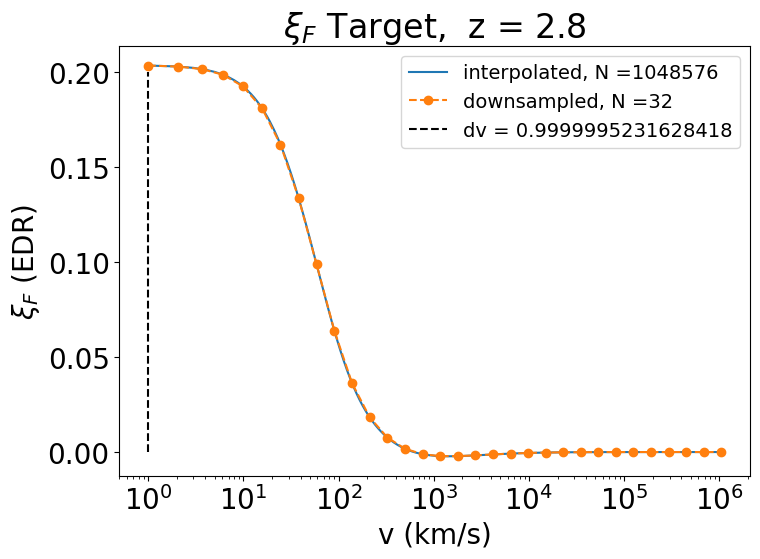

In [52]:
plt.figure(figsize=(8, 6))
plt.rcParams.update({'font.size': 20})

plt.semilogx(new_v_array[1:], xif_interp_fit[1:], label='interpolated, N =' +str(new_size))
plt.semilogx(v_array_downsampled, xif_target_downsampled, label='downsampled, N =' +str(downsample_size), ls='--', marker='o')
plt.xlabel('v (km/s)')
plt.ylabel(r'$\xi_F$ (EDR)')
plt.title(r'$\xi_F$ Target,  z = '+str(zlist[redshift_index]))
plt.vlines(dv, 0, 0.20, color='black', ls='--', label='dv = '+str(dv))
plt.legend(fontsize=14)
plt.tight_layout()
plt.show()


Now solve for xi_G using the downsampled xi_F target

In [53]:

xi_f_target = xif_target_downsampled

# Split indices: where velocity is above threshold

# choose a cutoff velocity such that low-v extrapolation is smooth (e.g. 10-15 km/s)
cutoff_v = 15.0
v_fit_mask = v_array_downsampled >= cutoff_v

v_fit = v_array_downsampled[v_fit_mask]
xi_f_fit = xi_f_target[v_fit_mask]

xi_g_initial_guess = np.full(xi_f_fit.size, 0.1)

def objective(xi_g, z, xi_f_target_subset):
    xi_f_calculated = np.array([lognXiFfromXiG_pointwise(z, xi_g_i, *mini.values) for xi_g_i in xi_g])
    return xi_f_calculated - xi_f_target_subset

##################################

time_1 = time.strftime("%H:%M:%S")
print("Start Time: ", time_1)
start_time = time.time()

result = least_squares(objective, xi_g_initial_guess, 
                       args=(zlist[redshift_index], xi_f_fit))
xi_g_fit = result.x

# Create extrapolator (can use linear or cubic, just ensure fill_value='extrapolate')
xi_g_extrapolator = interp1d(
    v_fit, xi_g_fit, kind='linear', 
    fill_value='extrapolate', 
    bounds_error=False
)

# Apply to full array
xi_g_full = xi_g_extrapolator(v_array_downsampled)

time_2 = time.strftime("%H:%M:%S")
print("End Time: ", time_2)

end_time = time.time()  # Get the new current time in seconds
elapsed_time = end_time - start_time  # Calculate elapsed time
# Convert elapsed time to minutes and seconds
minutes = int(elapsed_time // 60)
seconds = int(elapsed_time % 60)
print(f"Elapsed Time: {minutes} min {seconds} sec")
print("Size = "+str(downsample_size))

##################################




Start Time:  11:03:27
End Time:  11:03:29
Elapsed Time: 0 min 2 sec
Size = 32


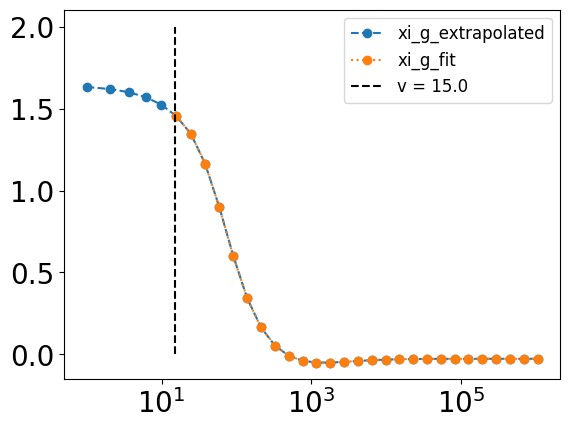

In [56]:
plt.semilogx(v_array_downsampled, xi_g_full, 'o', label='xi_g_extrapolated', ls='--')
plt.semilogx(v_fit, xi_g_fit, 'o', label='xi_g_fit', ls='dotted')
# plt.xlim(0,20)
plt.vlines(cutoff_v, 0, 2, color='black', ls='--', label=f'v = {cutoff_v}')
plt.legend(fontsize=12)
plt.show()

In [57]:
# check that solution is smooth
np.isclose(objective(xi_g_fit, zlist[redshift_index], xi_f_target[v_fit_mask]), 0)

array([ True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True])

In [59]:
zero_point = xi_g_full[0]

print(f"Input sigma2 from mean Flux:    {mini.values['sigma2']}")
print(f"Calculated sigma2 from Xi_G(0): {xi_g_fit[0]}")
print(f"Difference:                     {np.abs(mini.values['sigma2']-xi_g_fit[0])}\n")

print(f"Extrapolated zero point:        {zero_point}")
print(f"Difference:                     {np.abs(mini.values['sigma2']-zero_point)}")


Input sigma2 from mean Flux:    1.5038053359999608
Calculated sigma2 from Xi_G(0): 1.4536585127645971
Difference:                     0.05014682323536368

Extrapolated zero point:        1.6316977597059772
Difference:                     0.1278924237060164


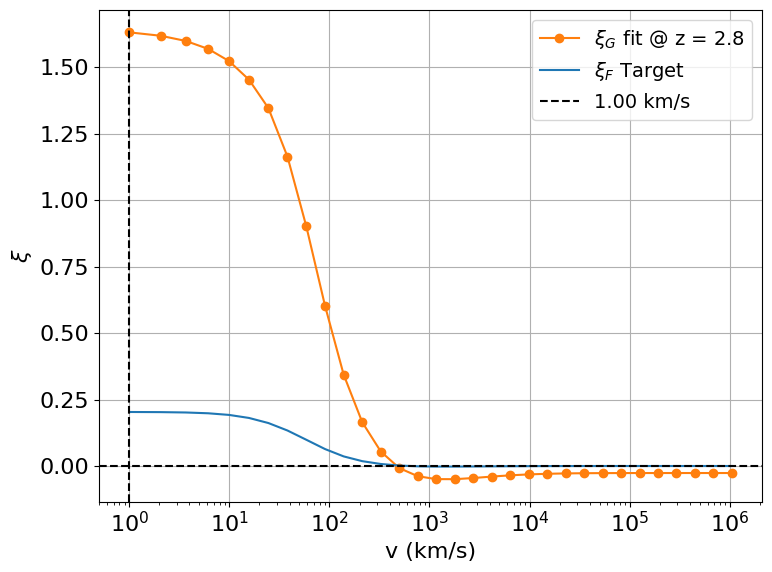

In [62]:
plt.figure(figsize=(8, 6))
plt.rcParams.update({'font.size': 16})

plt.semilogx(v_array_downsampled, xi_g_full, color='tab:orange', marker='o', label= r'$\xi_G$ fit @ z = '+str(zlist[redshift_index]))
# plt.vlines(dv, 0, 2, ls='--', color='black', label='dv = '+str(dv))

plt.semilogx(v_array_downsampled, xi_f_target, label = r'$\xi_F$ Target', color = 'tab:blue', alpha=1.0)
# plt.semilogx(v_array_downsampled, xi_f_optimized, label=r"$\xi_F$ Fit", color="tab:green", ls='none', marker='o', alpha=0.4)

plt.axhline(y=0.0, color='black', linestyle='--')
plt.axvline(x=dv, color='black', linestyle='--', label=f"{dv:.2f} km/s")
# plt.axvline(x=10, ls='--', color='grey', label='v = '+str(10))

plt.xlabel('v (km/s)')
plt.ylabel(r'$\xi$')
plt.legend(fontsize=14)
plt.tight_layout()
plt.grid()
plt.show()

# plt.savefig('xiG_Fit')

Now calculate xi_f optimized / fit from xi_g_fit

(note the cutoff at small v! we need to extrapolate so it is smooth)

In [63]:
xi_f_optimized = np.array([lognXiFfromXiG_pointwise(zlist[redshift_index], xi_g_i, *mini.values) for xi_g_i in xi_g_full])

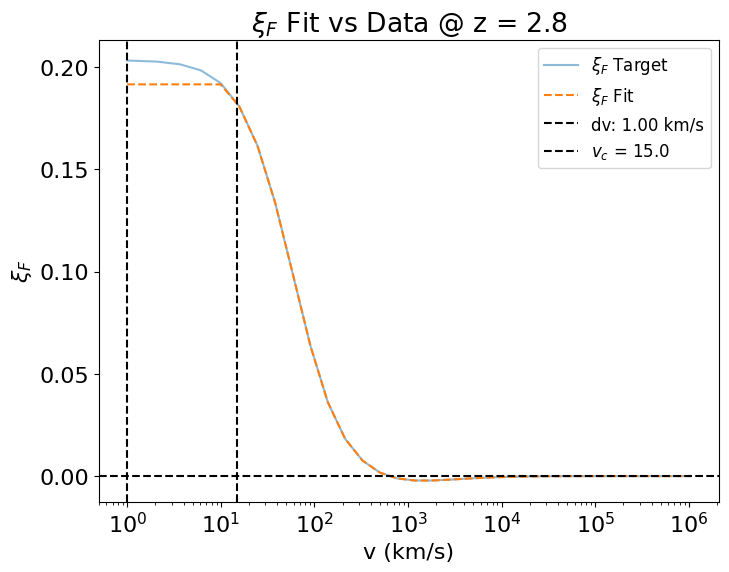

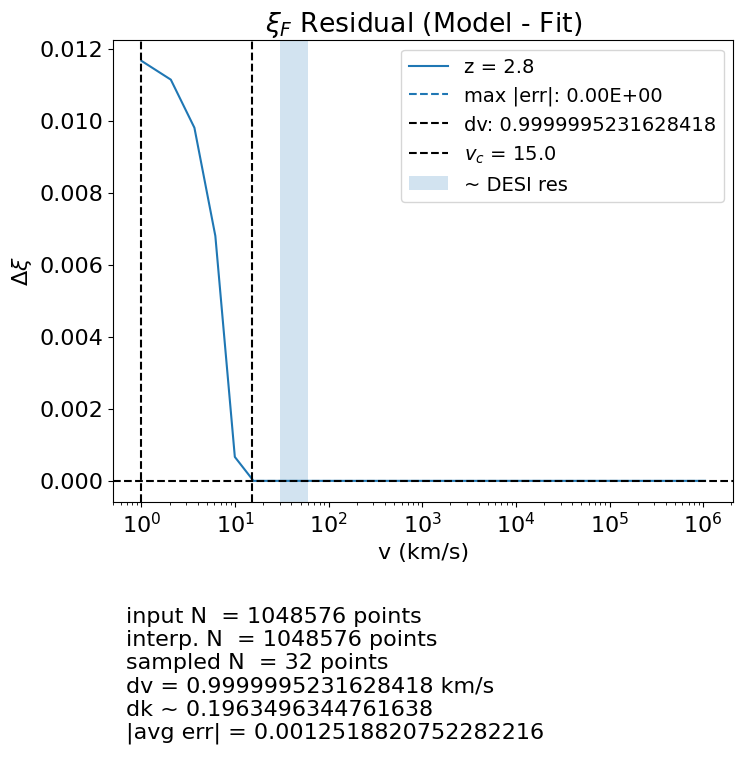

In [64]:
# plot xi F

plt.figure(figsize=(8, 6))
plt.rcParams.update({'font.size': 16})

##############################################

dif_xi_f = xi_f_target - xi_f_optimized
abs_dif_xi_f = np.abs(dif_xi_f)

max_y = dif_xi_f[np.argmax(abs_dif_xi_f)]  # This gives the actual value (+/-) farthest from 0
max_x = v_array[np.argmax(abs_dif_xi_f)]

##############################################

plt.semilogx(v_array_downsampled, xi_f_target, label = r'$\xi_F$ Target', color = 'tab:blue', alpha=0.5)
# plt.semilogx(v_array_downsampled, xi_f_optimized, label=r"$\xi_F$ Fit", color="tab:orange", ls='--', marker='o')
plt.semilogx(v_array_downsampled, xi_f_optimized, label=r"$\xi_F$ Fit", color="tab:orange", ls='--')

plt.axhline(y=0.0, color='black', linestyle='--')
plt.axvline(x=dv, color='black', linestyle='--', label=f"dv: {dv:.2f} km/s")
# plt.axvline(x=10, ls='--', color='grey', label='v = '+str(10))
# plt.axvline(x=150, ls='--', color='red', label='v = '+str(150))
# plt.axvspan(30, 60, alpha=0.2, label='~ DESI res')
plt.axvline(cutoff_v, color='black', ls='--', label=rf'$v_c$ = {cutoff_v}')
plt.legend(fontsize=12)
plt.xlabel('v (km/s)')
plt.ylabel(r'$\xi_F$')
plt.title(r"$\xi_F$ Fit vs Data @ z = "+str(zlist[redshift_index]))
plt.show()

##############################################

plt.figure(figsize=(8, 6))
plt.rcParams.update({'font.size': 16})

plt.semilogx(v_array_downsampled, dif_xi_f, label = 'z = '+str(zlist[redshift_index]), color = 'tab:blue')
plt.axhline(y=0.0, color='black', linestyle='--')
plt.axvline(x=max_x, color='tab:blue', linestyle='--', label=f"max |err|: {max_x:.2E}")
plt.axvline(x=dv, color='black', linestyle='--', label=f"dv: {dv}")
# plt.axvline(x=10, ls='--', color='grey', label='v = '+str(10))
plt.axvline(cutoff_v, color='black', ls='--', label=rf'$v_c$ = {cutoff_v}')
plt.axvspan(30, 60, alpha=0.2, label='~ DESI res')
plt.xlabel('v (km/s)')
plt.ylabel(r'$\Delta \xi$')
plt.legend(fontsize=14)
plt.title(r"$\xi_F$ Residual (Model - Fit)")

txt11 = "input N  = "+str(numvpoints)+" points \n"
txt12 = "interp. N  = "+str(new_size)+" points \n"
txt13 = "sampled N  = "+str(downsample_size)+" points \n"
txt2 = "dv = "+str(dv)+" km/s \n"
txt3 = "dk ~ "+str(2*np.pi/((v_array_downsampled.size)*dv)) + '\n'
txt5 = "|avg err| = " + str(np.abs(np.average(dif_xi_f))) + '\n'
# txt6 = "max err = " + str(max_y) + " at v = " + str(max_x) + "km/s \n"
txt  =  txt11 + txt12 + txt13 + txt2 + txt3 + txt5 #+ txt6 #+ txt4 

plt.text(0.02, -0.4, txt, ha='left', va='center', transform=plt.gca().transAxes)
plt.show()

## Extrapolating xi_g to get the full xi_g

zero val: 1.6316977597059772


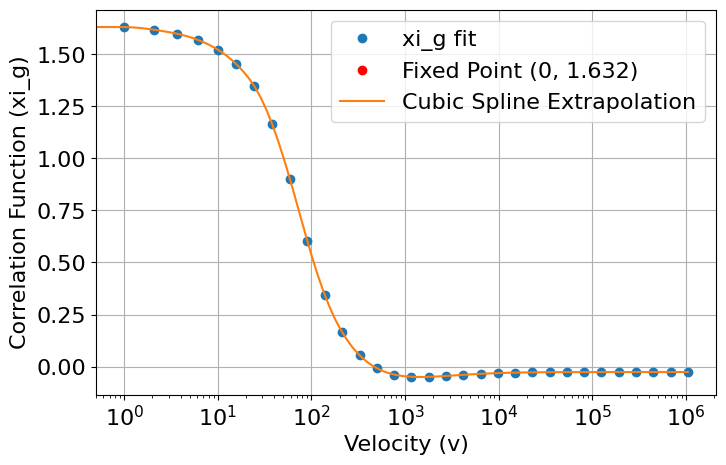

In [68]:

# Define the new velocity array: log-spaced including v=0
v_extrapolated = np.logspace(np.log10(1), np.log10(max(v_array_downsampled)), num=100)  # Start from 1 (to avoid log(0))
v_extrapolated = np.insert(v_extrapolated, 0, 0)  # Manually insert v=0

# Insert the fixed point (at v=0)
zero_val = zero_point
print(f'zero val: {zero_val}')
xi_g_new_vals = np.insert(xi_g_full, 0, zero_val)
v_extended = np.insert(v_array_downsampled, 0, 0)

###########################################################

# Create cubic spline interpolation with extrapolation
spline = CubicSpline(v_extended, xi_g_new_vals, bc_type='natural')

# Compute the extrapolated xi_g values
xi_g_extrapolated = spline(v_extrapolated)

#############################################################

# Plot results
plt.figure(figsize=(8, 5))
plt.plot(v_array_downsampled, xi_g_full, 'o', label='xi_g fit')
plt.plot(0, zero_val, 'ro', label=f'Fixed Point (0, {zero_val:.3f})')
plt.plot(v_extrapolated, xi_g_extrapolated, '-', label='Cubic Spline Extrapolation')
plt.xscale('log')  # Log-scale to visualize properly
# plt.xlim([-0.1,100])
plt.xlabel('Velocity (v)')
plt.ylabel('Correlation Function (xi_g)')
plt.legend(loc='upper right')
plt.grid()
plt.show()


#### check that xi_f is recovered

note: because of how the functions are defined, and the cutoff velocity, xi_f cannot be perfectly revovered this way! Especially at small v

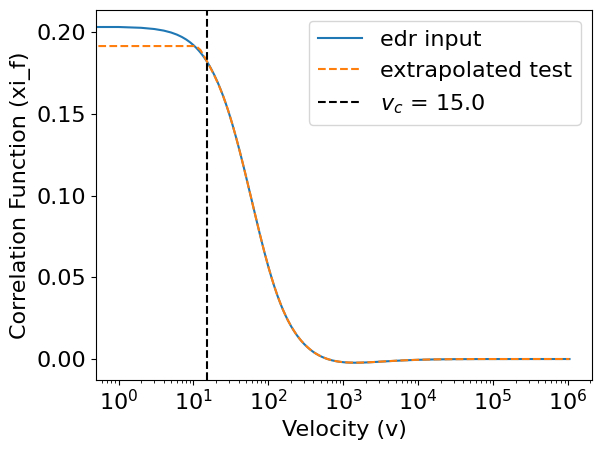

In [74]:
xi_f_optimized_extrapolated = np.array([lognXiFfromXiG_pointwise(zlist[redshift_index], xi_g_i, *mini.values) for xi_g_i in xi_g_extrapolated])

plt.semilogx(v_array, xif_edr_fit[redshift_index], label='edr input')
plt.semilogx(v_extrapolated, xi_f_optimized_extrapolated, label='extrapolated test', ls='--')
plt.axvline(cutoff_v, color='black', ls='--', label=rf'$v_c$ = {cutoff_v}')
# plt.xlim(10e-2, 10e2)
plt.xlabel('Velocity (v)')
plt.ylabel('Correlation Function (xi_f)')
plt.legend()
plt.show()

Oversampled velocity shape: (1048576,)
Oversampled xif shape: (1048576,)


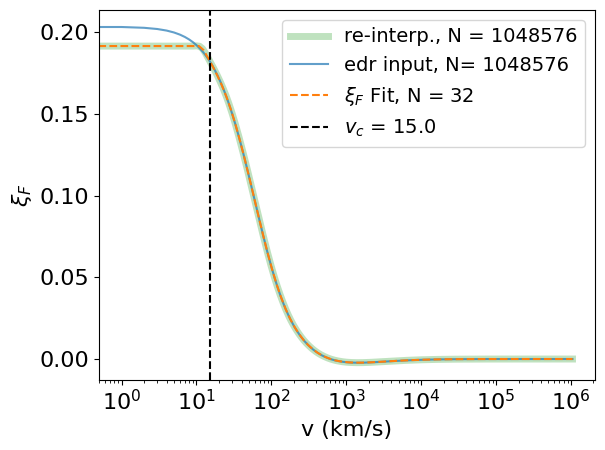

In [75]:

# interpolate the extrapolated xi_f

# Step 1: Generate the original (fine) velocity array (2^20 points)
v_fine = np.linspace(v_extrapolated.min(), v_extrapolated.max(), 2**20)  # Linearly spaced

# Step 2: Interpolate xig onto the fine velocity grid
cs = CubicSpline(v_extrapolated, xi_f_optimized_extrapolated)  # Create cubic spline interpolator
xif_fine = cs(v_fine)  # Evaluate at fine velocity points

# Output: xig_fine and v_fine now contain 2^20 points
print("Oversampled velocity shape:", v_fine.shape)  # Should be (2^20,)
print("Oversampled xif shape:", xif_fine.shape)  # Should be (2^20,)

plt.semilogx(v_fine, xif_fine, label='re-interp., N = '+str(v_fine.size), color='tab:green', lw=5, alpha=0.3)
plt.semilogx(v_array, xif_edr_fit[redshift_index], label='edr input, N= '+str(v_array.size), color = 'tab:blue', alpha=0.7)
plt.semilogx(v_extrapolated, xi_f_optimized_extrapolated, label=r"$\xi_F$ Fit, N = "+str(xi_f_optimized.size), color="tab:orange", ls='--')
plt.axvline(cutoff_v, color='black', ls='--', label=rf'$v_c$ = {cutoff_v}')
plt.xlabel('v (km/s)')
plt.ylabel(r'$\xi_F$')
plt.legend(fontsize=14)
plt.show()
# plt.title(r"$\xi_F$ Residual (EDR - Fit)")

In [76]:
# check new velocity spacing

dv_fine = np.diff(v_fine) 

# Check if the spacing is constant
print("Min spacing:", np.min(dv_fine))
print("Max spacing:", np.max(dv_fine))
print("Mean spacing:", np.mean(dv_fine))

new_dv = np.mean(dv_fine)

# If the min and max values differ significantly, the grid is not uniform
if np.allclose(np.min(dv_fine), np.max(dv_fine), rtol=1e-6):
    print("Velocity grid is evenly spaced ✅")
else:
    print("Velocity grid is NOT evenly spaced ❌")


Min spacing: 0.9999995231628418
Max spacing: 0.9999995231628418
Mean spacing: 0.9999995231628418
Velocity grid is evenly spaced ✅


## get P_G from xi_G using curvefit

Now we can take our xi_G solution and mirror it to get the full correlation function, FFT to get P_G, and use that to generate mocks

Note the smooth extrapolation now, without a velocity cutoff!

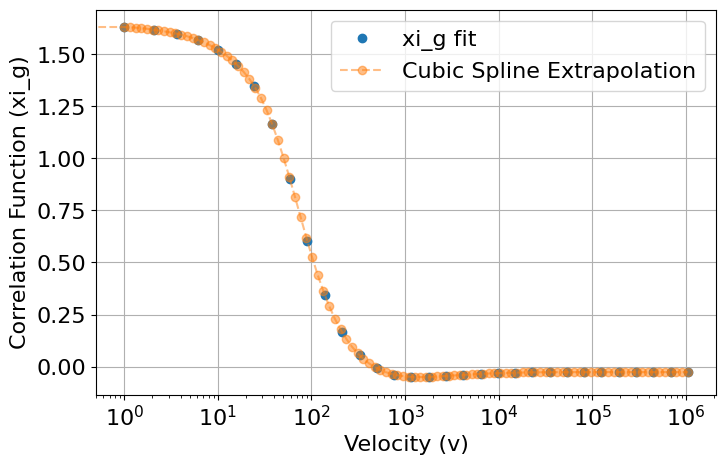

In [77]:
# Plot results
plt.figure(figsize=(8, 5))
plt.plot(v_array_downsampled, xi_g_full, 'o', label='xi_g fit')
# plt.plot(0, 1.55, 'ro', label='Fixed Point (0,'+str(zero_val)+')')
plt.plot(v_extrapolated, xi_g_extrapolated, '--', label='Cubic Spline Extrapolation',marker= 'o', alpha=0.5)
plt.xscale('log')  # Log-scale to visualize properly
plt.xlabel('Velocity (v)')
plt.ylabel('Correlation Function (xi_g)')
plt.legend()
plt.grid()
plt.show()


In [78]:
# interpolate the extrapolated xi_g fit to get even spacing 

# Step 1: Generate the original (fine) velocity array (2^20 points)
v_fit_fine = np.linspace(v_extrapolated.min(), v_extrapolated.max(), 2**20)  # Linearly spaced

# Step 2: Interpolate xig onto the fine velocity grid
cs = CubicSpline(v_extrapolated, xi_g_extrapolated)  # Create cubic spline interpolator
xi_g_fit_fine = cs(v_fit_fine)  # Evaluate at fine velocity points

# Output: xig_fine and v_fine now contain 2^20 points
print("Oversampled velocity shape:", v_fit_fine.shape)  # Should be (2^20,)
print("Oversampled xig shape:", xi_g_fit_fine.shape)  # Should be (2^20,)

plt.semilogx(v_fit_fine, xi_g_fit_fine, label='re-interpolated, N = '+str(xi_g_fit_fine.size), color='tab:green', lw=5, alpha=0.3)
plt.semilogx(v_extrapolated, xi_g_extrapolated, label=r"$\xi_G$ Fit, N = "+str(xi_g_extrapolated.size), color="tab:orange", ls='--')
plt.xlabel('v (km/s)')
plt.ylabel(r'$\xi$')
plt.legend(fontsize=14)
# plt.title(r"$\xi_F$ Residual (EDR - Fit)")

Oversampled velocity shape: (1048576,)
Oversampled xig shape: (1048576,)


In [79]:
dv_fit_fine = np.diff(v_fit_fine)  # Compute velocity spacing

# Check if the spacing is constant
print("Min spacing:", np.min(dv_fit_fine))
print("Max spacing:", np.max(dv_fit_fine))
print("Mean spacing:", np.mean(dv_fit_fine))

fit_xig_dv = np.mean(dv_fit_fine)

# If the min and max values differ significantly, the grid is not uniform
if np.allclose(np.min(dv_fit_fine), np.max(dv_fit_fine), rtol=1e-6):
    print("Velocity grid is evenly spaced ✅")
else:
    print("Velocity grid is NOT evenly spaced ❌")


Min spacing: 0.9999995231628418
Max spacing: 0.9999995231628418
Mean spacing: 0.9999995231628418
Velocity grid is evenly spaced ✅


In [80]:
def mirror_xiG(safe_z, half_v, half_xig): 
    file_v = half_v        # First column
    file_xiG = half_xig   # Second column

    def truncate_trailing_zeros(x, y):
        # Find the last index where y is nonzero
        last_nonzero_index = np.max(np.nonzero(y))

        # Ensure at least one zero remains at the end
        if last_nonzero_index < len(y) - 1 and y[last_nonzero_index + 1] == 0:
            last_nonzero_index += 1  # Keep the first zero after the last nonzero value

        return x[:last_nonzero_index + 1], y[:last_nonzero_index + 1]

    # v_truncated, xiG_truncated = truncate_trailing_zeros(file_v, file_xiG)
    v_truncated, xiG_truncated = file_v, file_xiG

    # Interpolate linearly (constant dv)
    file_v_fine = np.linspace(v_truncated.min(), v_truncated.max(), 2**20)
    cs = CubicSpline(v_truncated, xiG_truncated)
    file_xi_g_fine = cs(file_v_fine)

    dv_fit_fine = np.diff(file_v_fine)
    v_spacing = np.mean(dv_fit_fine)

    v_full = np.concatenate(
        [file_v_fine, file_v_fine + file_v_fine[-1] + v_spacing])

    # Mirror the correlation function values
    xig_full = np.concatenate([file_xi_g_fine, file_xi_g_fine[::-1]])

    return file_v_fine, file_xi_g_fine, v_full, xig_full

def calc_PG(safe_z, v_array, xig_array):
    full_v = v_array
    full_xiG = xig_array
    full_v_spacing = full_v[1] - full_v[0]

    # Compute power spectrum
    file_xig_power = np.fft.rfft(full_xiG) * full_v_spacing
    file_xig_power = np.abs(file_xig_power)  # np.abs vs .real ?
    file_xig_karr = 2 * np.pi * \
        np.fft.rfftfreq(len(full_xiG), d=full_v_spacing)

    return file_xig_karr, file_xig_power

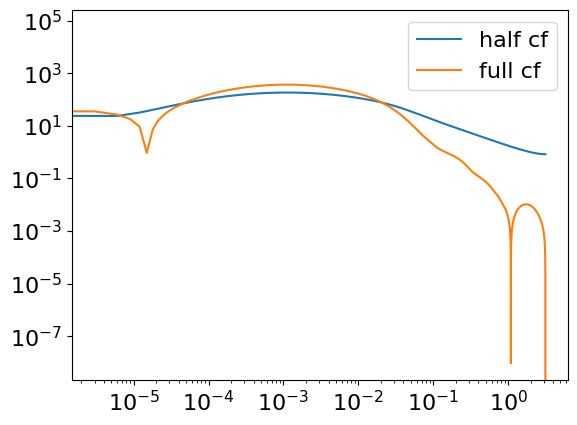

In [83]:
v_half, xig_half, v_full, xig_full = mirror_xiG(safe_z='2-8', half_v= v_extrapolated, half_xig=xi_g_extrapolated)

k_array_half, power_array_half = calc_PG(safe_z='2-8', v_array=v_half, xig_array=xig_half)
k_array_full, power_array_full = calc_PG(safe_z='2-8', v_array=v_full, xig_array=xig_full)

plt.loglog(k_array_half, power_array_half, label='half cf')
plt.loglog(k_array_full, power_array_full, label='full cf')
plt.legend()
plt.show()

#### gen test

A quick mock generation test, see the other notebook for a full in-depth overview

In [84]:

safe_z = str(target_redshift).replace('.', '-')

####################################

seed = 100     # for repeatability
size = 2**22
dv   = 1.0
# dv = 0.5

c = 299792.458  # speed of light in km/s
lambda_0 = 1216 # rest wavelength in Angstroms (for Lyα)

PD13_PIVOT_K = 0.009  # note: k_0
PD13_PIVOT_Z = 3.0    # note: z0 = 3

def lambda_c(z, lambda_0 = lambda_0):
    lambda_c = (1+z)*lambda_0
    return(lambda_c)   
    
lambda_min = 3600  # minimum wavelength in Angstroms
lambda_max = 9800  # maximum wavelength in Angstroms

velocity_grid = np.arange(size) - size/2

# Rescale velocity field to match the wavelength range
# Calculate the velocity needed to match the wavelength range
v_min = (lambda_min / lambda_0 - 1) * c
v_max = (lambda_max / lambda_0 - 1) * c

# fitting parameters from mean flux           
tau0_fid   = mini.values['tau0']
tau1_fid   = mini.values['tau1']
nu_fid     = mini.values['nu']
sigma2_fid = mini.values['sigma2']


In [85]:

#### FUNCTIONS ####

def delta_transform_1d(file_k_array, file_power_array, 
                       gaussian_random_field_k, dv):
    N_rfft = gaussian_random_field_k.shape[0]
    N = 2 * (N_rfft - 1)  # real-space size
    k = np.fft.rfftfreq(N, d=dv) * 2 * np.pi  # k [1/km]
    
    # Interpolate with smooth spline and constant extrapolation
    power_interp = InterpolatedUnivariateSpline(file_k_array, 
                                                file_power_array, 
                                                k=1, ext=1)
    P_k = power_interp(k)

    # Ensure non-negative and finite
    P_k = np.where((P_k > 0) & np.isfinite(P_k), P_k, 0.0)

    # Scale the white noise in k-space
    delta_b_tilde = gaussian_random_field_k * np.sqrt(P_k / dv)

    # Inverse FFT to get real-space correlated Gaussian field
    delta_b = np.fft.irfft(delta_b_tilde, n=N) / dv

    return delta_b_tilde, delta_b, P_k


def a2_z(zp, nu=nu_fid, z0=PD13_PIVOT_Z):
    return np.power((1. + zp) / (1.+z0), -nu)


def a_z(zp, nu=nu_fid, z0=PD13_PIVOT_Z):
    return np.sqrt(np.power((1. + zp) / (1.+z0), -nu))


# note: variance of the field, vs the one set by mean flux (?)
def lognormal_transform(delta_z, sigma2_z):
    n_z = np.exp( (2 * (delta_z) - (sigma2_z)))
    return(n_z)


def t_of_z(zp, tau0=tau0_fid, tau1=tau1_fid, z0= PD13_PIVOT_Z):
    return tau0 * np.power((1. + zp) / (1.+z0), tau1)


def x_of_z(t_z, n_z):
    return t_z * n_z


def f_of_z(x_z):
    return np.exp(-x_z)


def prefactor(variance):
    prefactor = 1 / (np.sqrt(variance) * np.sqrt(2 * np.pi))
    return(prefactor)


def xz(z, sigma2=sigma2_fid, tau0=tau0_fid, tau1=tau1_fid, 
       nu=nu_fid, z0=PD13_PIVOT_Z):
    return t_of_z(z, tau0, tau1, z0) * np.exp(-a2_z(z, nu, z0) * sigma2)


def mean_flux(z, variance, z0=PD13_PIVOT_Z):
    integrand = lambda x: np.exp((-(x**2) / (2 * variance)) - 
                                 ((xz(z)) * np.exp(2 * (a_z(z)) * x)))
    integral = integrate.quad(integrand, -np.inf, np.inf)[0]
    value = prefactor(variance) * integral
    return(value)


def turner24_mf(z):
    tau_0 = -2.46e-3
    gamma = 3.62
    return np.exp(tau_0 * (1 + z)**gamma)


def delta_F(z, variance, input_flux, z0=PD13_PIVOT_Z):
    f_bar = input_flux.mean()
    # f_bar = mean_flux(z,variance,z0)
    flux = input_flux
    delta_f = (flux - f_bar) / (f_bar)
    return(delta_f)


def P_F(delta_f, dv):
    L = delta_f.size * dv
    delta_f_tilde = np.fft.rfft(delta_f) * dv
    P_F = np.abs(delta_f_tilde)**2 / L
    return P_F


def fit_PD13Lorentz(delta_f, dv, z):
    power = P_F(delta_f, dv)
    N = len(delta_f)
    kmodes = np.fft.rfftfreq(n=N, d=dv) * 2 * np.pi
    # w_k =  (kmodes > 0) & (kmodes < 10e1)   
    w_k =  (kmodes > 0) & (kmodes < 10e2)   
    bins = 20000
    statistic, bin_edges, binnumber = binned_statistic(x=kmodes[w_k],
                                                       values=power[w_k],
                                                       statistic='mean', 
                                                       bins = bins)    
    bin_centers = 0.5 * (bin_edges[1:] + bin_edges[:-1])
 
    window = (bin_centers > 0) & (bin_centers < 1.0)  

    valid = np.isfinite(statistic) & np.isfinite(bin_centers)
    bin_centers = bin_centers[valid]
    statistic = statistic[valid]

    p0 = (0.07, -2.5, -0.1, 3.5, 0.3, 700)
    
    popt_mock, pcov_mock = curve_fit(
        lambda k, A, n, alpha, B, beta, lmd: evaluatePD13Lorentz(
            (k,z), A, n, alpha, B, beta, lmd),
        bin_centers, statistic, p0=p0, maxfev=20000)
    
    return bin_centers[window], statistic[window], *popt_mock
    # return bin_centers, statistic, *popt_mock


def evaluatePD13Lorentz(X, A, n, alpha, B, beta, lmd):
    k, z = X
    q0 = k / PD13_PIVOT_K + 1e-10
    result = (A * np.pi / PD13_PIVOT_K) * np.power(
        q0, 2. + n + alpha * np.log(q0)) / (1. + lmd * k**2)
    if z is not None:
        x0 = (1. + z) / (1. + PD13_PIVOT_Z)
        result *= np.power(q0, beta * np.log(x0)) * np.power(x0, B)
    return result


In [86]:
#### MOCK GENERATION ####

# optionally use a seed for repeatability 
gaussian_random_field = np.random.default_rng().normal(size=size)
gaussian_random_field_k = np.fft.rfft(gaussian_random_field) * dv
kmodes = (np.fft.rfftfreq(n=size, d=dv) * 2 * np.pi) #+ 1e-12 


delta_b_tilde, delta_b_v, P_k_filtered = delta_transform_1d(
    k_array_full, power_array_full, gaussian_random_field_k, dv)

variance_1d = sigma2_fid
variance_1d_field = delta_b_v.var()

delta_b_z = delta_b_v * a_z(zp = target_redshift)

redshifted_variance_1d = variance_1d * a2_z(zp = target_redshift)
redshifted_variance_1d_field = variance_1d_field * a2_z(zp = target_redshift)

n_z = lognormal_transform(delta_b_z, redshifted_variance_1d)
t_z = t_of_z(zp=target_redshift)
x_z = x_of_z(t_z, n_z)
f_z = f_of_z(x_z)



Note the difference between the variance of the field, and the variance prefered by the mean flux fit

In [88]:
print(f'variance_1d:       {variance_1d}')
print(f'variance_1d_field: {variance_1d_field}\n')

print(f'redshifted_variance_1d:       {redshifted_variance_1d}')
print(f'redshifted_variance_1d_field: {redshifted_variance_1d_field}')

variance_1d:       1.5038053359999608
variance_1d_field: 1.6885967205059473

redshifted_variance_1d:       1.6801483445254248
redshifted_variance_1d_field: 1.8866092017439169


In [90]:

#### MEASURE POWER ####

delta_f = delta_F(z = target_redshift, 
                  variance = variance_1d_field, 
                  input_flux = f_z)

test_power = P_F(delta_f, dv)

bin_centers, stat, *popt_mock_param = fit_PD13Lorentz(delta_f, dv, 
                                                      target_redshift)

mock_fit = evaluatePD13Lorentz((bin_centers, target_redshift), 
                               *popt_mock_param)
desi_model = evaluatePD13Lorentz((bin_centers, target_redshift), 
                                 *DESI_EDR_PARAMETERS)
naim_fit = evaluatePD13Lorentz((bin_centers, target_redshift), 
                               *Naim_2020_parameters)

percent_diff_mock_measure = 100 * (stat - desi_model) / desi_model
percent_diff_mock_fit     = 100 * (mock_fit - desi_model) / desi_model
percent_diff_naim_fit     = 100 * (naim_fit - desi_model) / desi_model


In [91]:
c = 299792.458        # km/s
delta_lambda = 0.8    # Angstrom (DESI)
lambda_lya = 1215.67  # Angstrom

def get_k_range_desi2025(z):
    """Return kmin and kmax (in s/km) for DESI DR1 resolution at redshift z."""
    R_z = (c * delta_lambda) / ((1 + z) * lambda_lya)
    k_max = 0.5 * np.pi / R_z  # s/km
    k_min = 0.001  # s/km, fixed by continuum limit
    return k_min, k_max
dynamic_k_min, dynamic_k_max = get_k_range_desi2025(target_redshift)


# 2020 mock paper k-range
wk_2020 = (bin_centers > 0.0005) & (bin_centers < 0.112)

# EDR measurement k-range
wk_2023 = (bin_centers > 0.000750) & (bin_centers < 0.035) # EDR measurement 

# 2025 measurement k-range
wk_2025 = (bin_centers > dynamic_k_min) & (bin_centers < dynamic_k_max)

# extended range
wk_extended = (bin_centers > 1e-5) & (bin_centers < 0.1) 

# custom, for display only
wk_custom = (bin_centers > 1e-4) & (bin_centers < 0.05) 


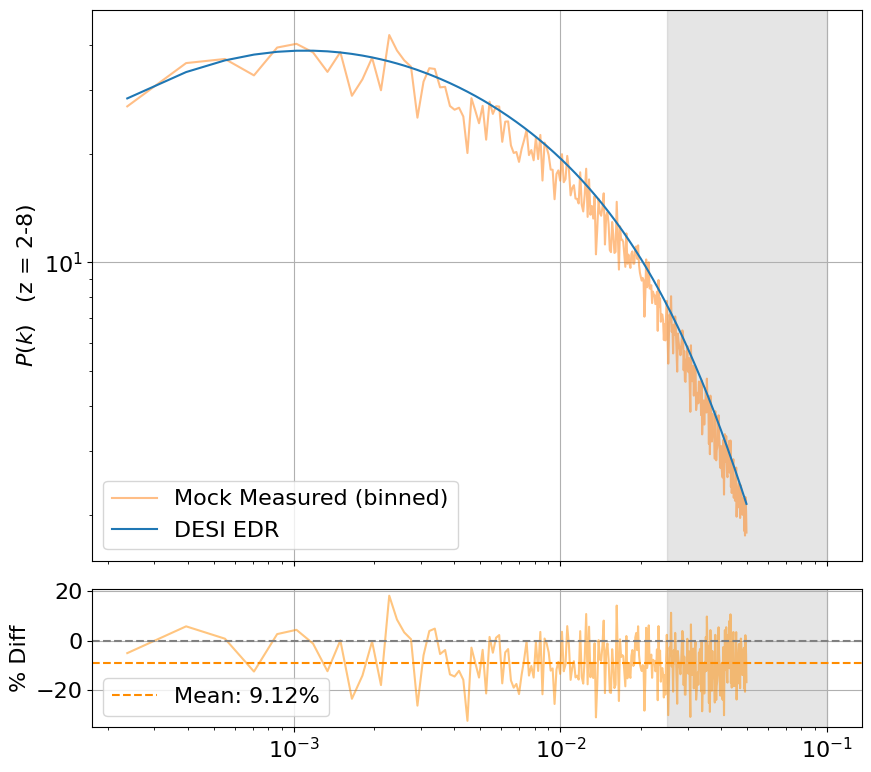

Mean: 9.12%


In [93]:

#### PLOT MEASURED POWER ####

w_k = wk_custom

fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(9, 8), sharex=True, 
                                    gridspec_kw={'height_ratios': [4, 1]})

ax1.loglog(bin_centers[w_k], stat[w_k], color='tab:orange', 
           label='Mock Measured (binned)', alpha=0.5)
ax1.loglog(bin_centers[w_k], desi_model[w_k], 
           color='tab:blue', label=r'DESI EDR')


# ax1.set_ylabel(r'$P_{1D}(k)$')
ax1.set_ylabel(rf'$P(k)$   (z = {safe_z})')
ax1.legend(loc='lower left')
ax1.grid(True)
# ax1.set_title(f'DESI vs. Mock Power Spectrum at z = {safe_z}')
ax1.axvspan(0.025, 0.1, alpha=0.2, color='grey')


ax2.semilogx(bin_centers[w_k], percent_diff_mock_measure[w_k], alpha=0.5,
             color='darkorange')
ax2.axhline(percent_diff_mock_measure[w_k].mean(), ls='--', color='darkorange', 
            label=f'Mean: {np.abs(percent_diff_mock_measure[w_k].mean()):.2f}%')
ax2.axhline(0, ls='--', color='gray')
ax2.set_ylabel('% Diff')
ax2.grid(True)
ax2.legend(loc='upper left')
ax2.axvspan(0.025, 0.1, alpha=0.2, color='grey')

plt.legend()
plt.tight_layout()
plt.show()

print(f'Mean: {np.abs(percent_diff_mock_measure[w_k].mean()):.2f}%')


Compare to desi edr data points

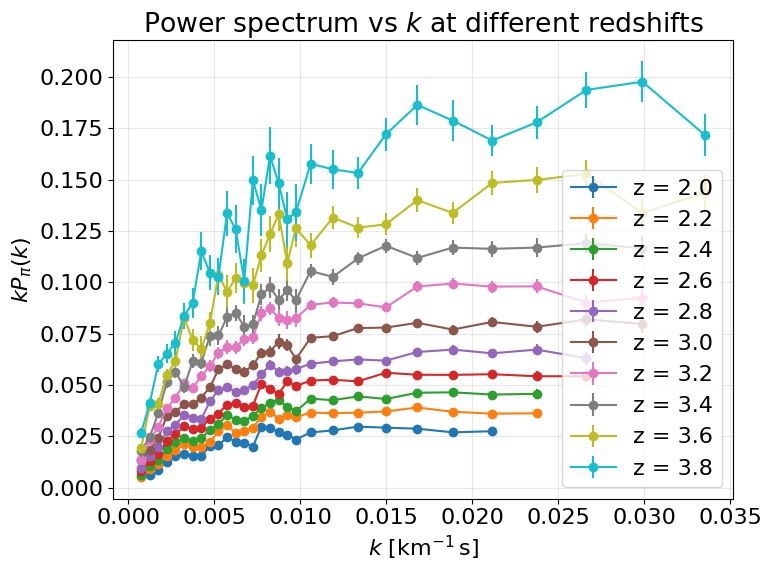

In [100]:

edr_data_path = '../Examples/figure8_qmle_desiedrp_results.txt'

# Read the file, using '|' as a separator and stripping whitespace
df = pd.read_csv(edr_data_path, sep='|', skiprows=1)
df = df.drop(columns=df.columns[[0, -1]])  # Drop extra empty columns from leading/trailing pipes
df.columns = ['kc', 'z', 'kPpi', 'kepi']   # Rename columns
df = df.apply(pd.to_numeric)               # Ensure all data is numeric

# Group by redshift and plot
plt.figure(figsize=(8, 6))
for z_val, group in df.groupby('z'):
    plt.errorbar(group['kc'], group['kPpi'], yerr=group['kepi'], fmt='o-', label=f'z = {z_val}')

plt.xlabel(r'$k$ [$\mathrm{km}^{-1}\,\mathrm{s}$]')
plt.ylabel(r'$kP_{\pi}(k)$')
plt.title("Power spectrum vs $k$ at different redshifts")
plt.grid(True, alpha=0.3)
plt.legend()
plt.tight_layout()
plt.show()

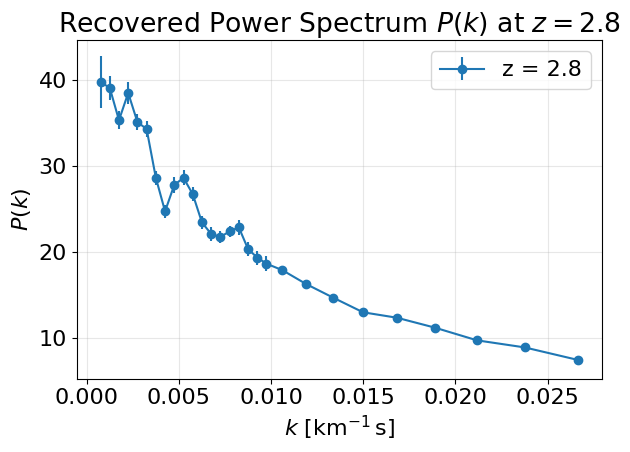

In [102]:
z_target = target_redshift
subset = df[df['z'] == z_target].copy()

# Recover P(k) and its uncertainty
subset['Pk'] = np.pi * subset['kPpi'] / subset['kc']
subset['Pk_err'] = np.pi * subset['kepi'] / subset['kc']

# Plot
plt.errorbar(subset['kc'], subset['Pk'], yerr=subset['Pk_err'], fmt='o-', label=f'z = {z_target}')
plt.xlabel(r'$k$ [$\mathrm{km}^{-1}\,\mathrm{s}$]')
plt.ylabel(r'$P(k)$')
plt.title(f"Recovered Power Spectrum $P(k)$ at $z={z_target}$")
plt.grid(True, alpha=0.3)
plt.legend()
plt.tight_layout()
plt.show()

# print(f'kmin = {subset['kc'][:].min()}')
# print(f'kmax = {subset['kc'][:].max()}')



In [103]:
def process_EDR_DATA(z_target):

    # Read the file, using '|' as a separator and stripping whitespace
    df = pd.read_csv(edr_data_path, sep='|', skiprows=1)
    df = df.drop(columns=df.columns[[0, -1]])  # Drop extra empty columns from leading/trailing pipes
    df.columns = ['kc', 'z', 'kPpi', 'kepi']   # Rename columns
    df = df.apply(pd.to_numeric)               # Ensure all data is numeric

    subset = df[df['z'] == z_target].copy()
    
    # Recover P(k) and its uncertainty
    subset['Pk'] = np.pi * subset['kPpi'] / subset['kc']
    subset['Pk_err'] = np.pi * subset['kepi'] / subset['kc']

    return subset['kc'], subset['Pk'], subset['Pk_err']

test_edr_k, test_edr_p, test_edr_err = process_EDR_DATA(target_redshift)

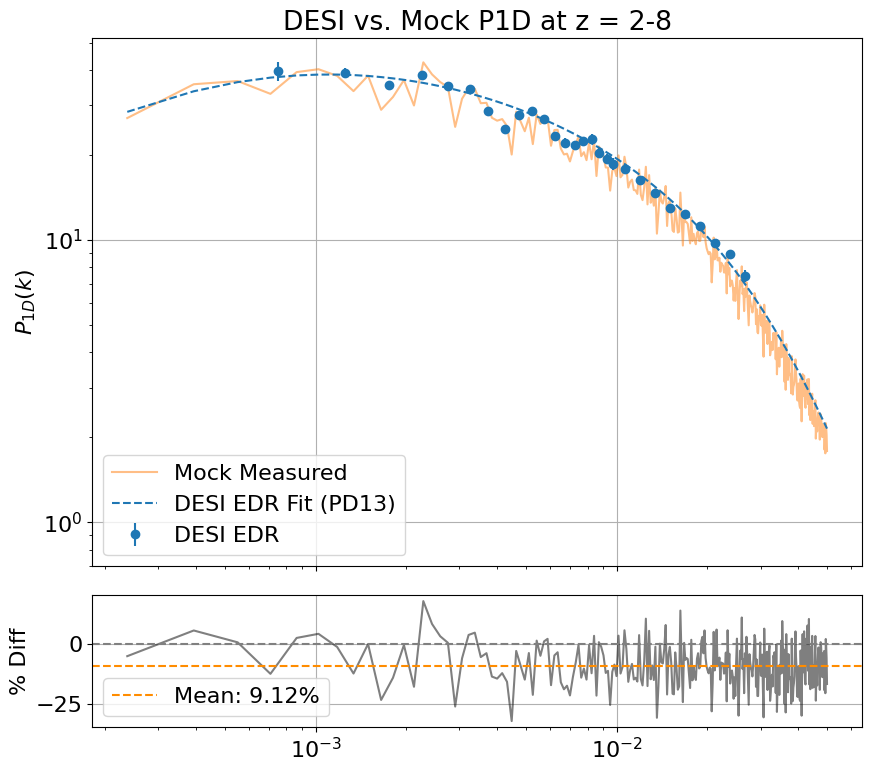

In [107]:

fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(9, 8), sharex=True, gridspec_kw={'height_ratios': [4, 1]})

mask = (bin_centers > 1e-4) & (bin_centers < 0.05)  # custom

# Upper plot
ax1.loglog(bin_centers[mask], stat[mask], color='tab:orange', label='Mock Measured', alpha=0.5)
ax1.loglog(bin_centers[mask], desi_model[mask], 
    color='tab:blue', label=r'DESI EDR Fit (PD13)', ls='--')
ax1.errorbar(subset['kc'], subset['Pk'], yerr=subset['Pk_err'], 
             fmt='o', label='DESI EDR', color='tab:blue')#, markerfacecolor='none')
ax1.set_ylabel(r'$P_{1D}(k)$')
ax1.legend(loc='lower left')
ax1.grid(True)
ax1.set_title(f'DESI vs. Mock P1D at z = {safe_z}')

# Lower plot (residuals)
ax2.semilogx(bin_centers[mask], percent_diff_mock_measure[mask], 
             color='black', alpha=0.5)
ax2.axhline(0, ls='--', color='gray')
ax2.axhline(percent_diff_mock_measure[mask].mean(), 
            ls='--', color='darkorange', 
           label= f'Mean: {np.abs(percent_diff_mock_measure[w_k].mean()):.2f}%')
ax2.set_ylabel('% Diff')
ax2.grid(True)
ax2.legend(loc='upper left')
plt.legend()
plt.tight_layout()
plt.show()


## compute power from xi_F

First, try using only half the CF

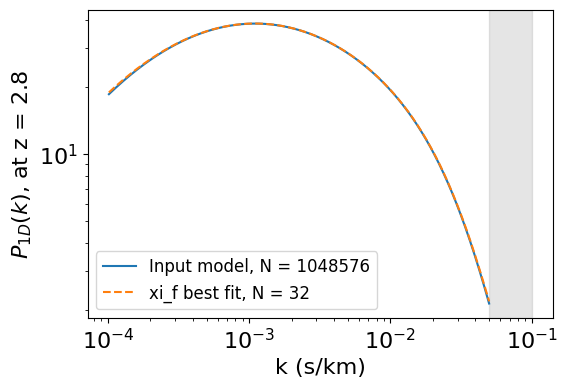

In [118]:

fit_power = np.fft.rfft(xif_fine) * new_dv * 2
fit_k_arr = 2 * np.pi * np.fft.rfftfreq(len(xif_fine), d=new_dv)

#########################################################################

p1d_precision = 1e-1
w_k = (k_arr > 1e-4) & (k_arr < 0.05)  # Window for k_arr
w_fit_k = (fit_k_arr > 1e-4) & (fit_k_arr < 0.05)  # Window for fit_k_arr
w_k_fine = (k_array_fine > 1e-4) & (k_array_fine < 0.05)  # Window for k_array_fine
ptrue = p1d_edr_fit[:, w_k].ravel()
e_p1d = p1d_precision * ptrue + 1e-8

#########################################################################

plt.figure(figsize=(6, 4))

plt.loglog(k_arr[w_k], p1d_edr_fit[redshift_index, w_k], color='tab:blue', 
           label=r'Input model, N = '+str(numvpoints))

plt.loglog(fit_k_arr[w_fit_k], fit_power[w_fit_k], 
           label = 'xi_f best fit, N = '+str(downsample_size), color='tab:orange', ls='--')

plt.axvspan(0.05, 0.1, alpha=0.2, color='grey')
plt.ylabel(r'$P_{1D}(k)$, at z = '+str(zlist[redshift_index]))
plt.xlabel('k (s/km)')
plt.legend(fontsize=12, loc='lower left')
plt.show()


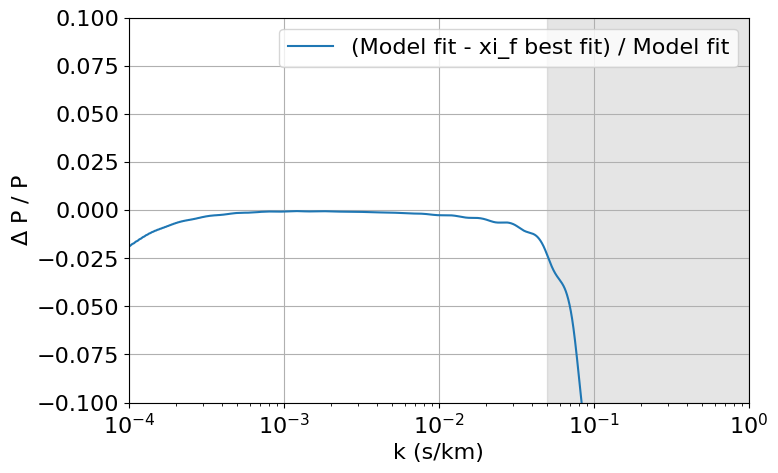

In [121]:

# Interpolate fit_power to match k_array
fit_power_interp = np.interp(k_arr, fit_k_arr, fit_power)

# Compute residual
delta_P = (p1d_edr_fit[redshift_index] - fit_power_interp) / p1d_edr_fit[redshift_index]

# Plot residual
plt.figure(figsize=(8, 5))
plt.semilogx(k_arr, delta_P, label = "(Model fit - xi_f best fit) / Model fit")
plt.axvspan(0.05, 1.0, alpha=0.2, color='grey')
plt.xlim([10e-5,10e-1])
plt.ylim(-0.5,0.5)
plt.xlabel('k (s/km)')
plt.ylabel(r"$\Delta$ P / P")
plt.legend()
plt.grid()
plt.ylim(-0.1,0.1)
plt.show()


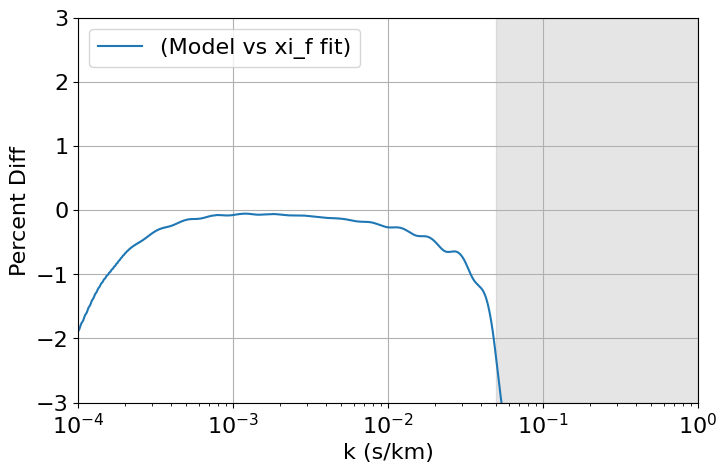

In [123]:

# Interpolate fit_power to match k_array
fit_power_interp = np.interp(k_arr, fit_k_arr, fit_power)

# Compute residual
percent_diff = 100 * ((p1d_edr_fit[redshift_index] - fit_power_interp) / p1d_edr_fit[redshift_index])

# Plot residual
plt.figure(figsize=(8, 5))
plt.semilogx(k_arr, percent_diff, label = "(Model vs xi_f fit)")
plt.axvspan(0.05, 1.0, alpha=0.2, color='grey')
plt.xlim([10e-5,10e-1])
plt.ylim(-10,10)
plt.xlabel('k (s/km)')
plt.ylabel("Percent Diff")
plt.legend()
plt.grid()
plt.ylim(-3,3)
plt.show()


#### Try mirroring xi_f and then getting power:

Mirroring the CF will recover the missing information and adjust the shape and amplitude of the final power

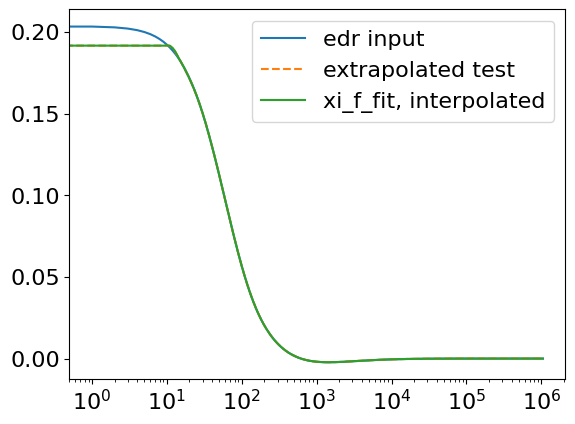

In [125]:
plt.semilogx(v_array, xif_edr_fit[redshift_index], label='edr input')
plt.semilogx(v_extrapolated, xi_f_optimized_extrapolated, label='extrapolated test', ls='--')
plt.semilogx(v_fine, xif_fine, label='xi_f_fit, interpolated')
plt.legend()
plt.show()

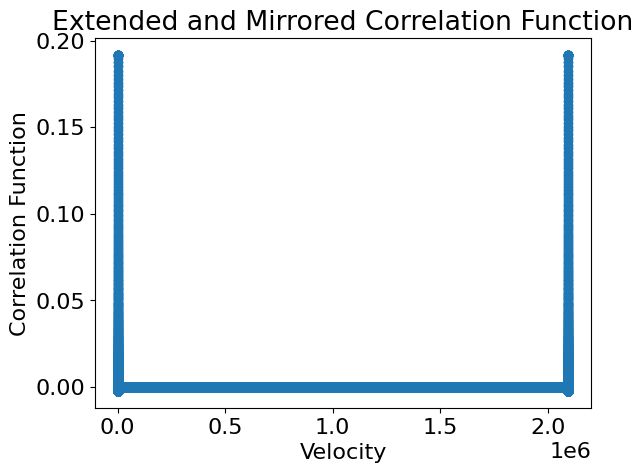

In [126]:
# Extend the velocity array
v_spacing = v_fine[1] - v_fine[0]  # Compute the step size
v_extended = np.concatenate([v_fine, v_fine + v_fine[-1] + v_spacing])

# Mirror the correlation function values
xi_f_extended = np.concatenate([xif_fine, xif_fine[::-1]])

# Plot the result
plt.plot(v_extended, xi_f_extended, marker='o', linestyle='-')
plt.xlabel("Velocity")
plt.ylabel("Correlation Function")
plt.title("Extended and Mirrored Correlation Function")
plt.show()

In [127]:

test_fit_power = np.fft.rfft(xi_f_extended) * v_spacing # mult. by dv
test_fit_k_arr = 2 * np.pi * np.fft.rfftfreq(len(xi_f_extended/2), d=v_spacing)

#########################################################################

p1d_precision = 1e-1

w_k = (k_arr > 1e-4) & (k_arr < 0.1)  # Window for k_arr
w_fit_k = (test_fit_k_arr > 1e-4) & (test_fit_k_arr < 0.1)  # Window for fit_k_arr
w_k_fine = (k_array_fine > 1e-4) & (k_array_fine < 0.1)  # Window for k_array_fine

ptrue = p1d_edr_fit[:, w_k].ravel()
e_p1d = p1d_precision * ptrue + 1e-8

#########################################################################


Note how it is a much better fit now! (except for high k)

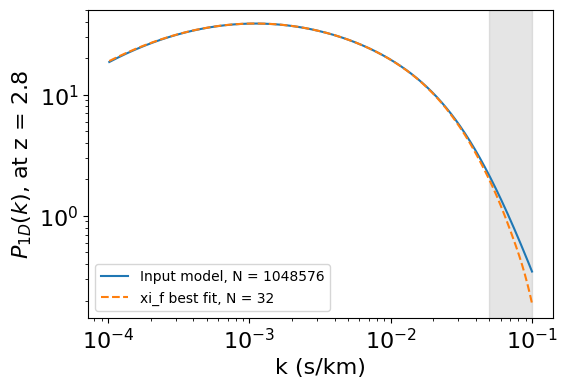

In [128]:

plt.figure(figsize=(6, 4))

# Extract data using your index mask (w_k)
temp_k = k_arr[w_k]
temp_p = p1d_edr_fit[redshift_index, w_k]
temp_e = np.full_like(temp_k, e_p1d[redshift_index])

# Normalize k_values on a log scale, then map alpha to a smooth range
log_k_values = np.log10(temp_k)  # Take log of k-values
log_k_min = np.min(log_k_values)
log_k_max = np.max(log_k_values)

plt.loglog(k_arr[w_k], p1d_edr_fit[redshift_index, w_k], color='tab:blue', 
           label=r'Input model, N = ' + str(numvpoints))

plt.loglog(test_fit_k_arr[w_fit_k], test_fit_power[w_fit_k], 
           label='xi_f best fit, N = ' + str(downsample_size), color='tab:orange', ls='--')

plt.axvspan(0.05, 0.1, alpha=0.2, color='grey')
plt.ylabel(r'$P_{1D}(k)$, at z = ' + str(zlist[redshift_index]))
plt.xlabel('k (s/km)')
plt.legend(fontsize=10, loc='lower left')

plt.show()


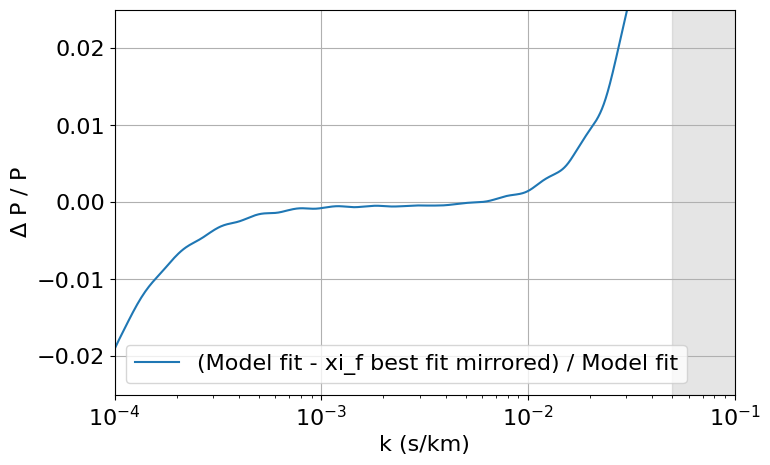

In [132]:

# Interpolate fit_power to match k_array
fit_power_interp_2 = np.interp(k_arr, test_fit_k_arr, test_fit_power)

# Compute residual
delta_P = np.real((p1d_edr_fit[redshift_index] - fit_power_interp_2) / p1d_edr_fit[redshift_index])

# Plot residual
plt.figure(figsize=(8, 5))
plt.semilogx(k_arr, delta_P, label = "(Model fit - xi_f best fit mirrored) / Model fit")
plt.axvspan(0.05, 1.0, alpha=0.2, color='grey')
plt.xlim([10e-5,10e-2])
plt.ylim(-delta_P.max(),delta_P.max())
plt.xlabel('k (s/km)')
plt.ylabel(r"$\Delta$ P / P")
plt.legend()
plt.grid()
plt.ylim(-0.025,0.025)
plt.show()


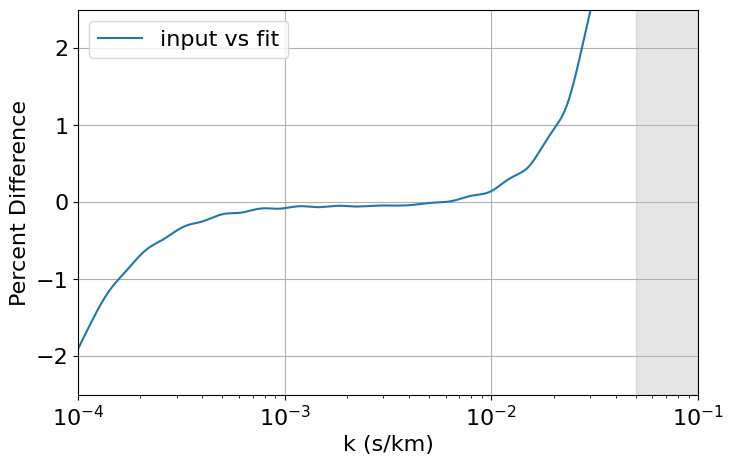

In [133]:

# Compute residual
percent_diff = 100 * np.real((p1d_edr_fit[redshift_index] - fit_power_interp_2) / p1d_edr_fit[redshift_index]) 

# Plot residual
plt.figure(figsize=(8, 5))
plt.semilogx(k_arr, percent_diff, label='input vs fit')
plt.axvspan(0.05, 1.0, alpha=0.2, color='grey')
plt.xlim([10e-5,10e-2])
plt.ylim(-10,10)
plt.xlabel('k (s/km)')
plt.ylabel("Percent Difference")
plt.legend(loc='upper left')
plt.grid()
plt.ylim(-2.5,2.5)
plt.show()


In [108]:
# DATA
rawdir1 = '/global/cfs/cdirs/desicollab/users/mherbold/tests/iron_data_vs_mocks/lyspeq_ouput/data_bals_masked/tests/results/picca-true/'
file1 = rawdir1 + 'desi-iron-bal_mask-n2_it1_quadratic_power_estimate_detailed.txt'

data1 = ascii.read(file1)


# MOCK
rawdir2 = '/global/cfs/cdirs/desicollab/users/mherbold/tests/iron_data_vs_mocks/lyspeq_ouput/iron_mock/output/tests/results/picca-true/'
ext = 'desi-iron-bal_mask-n2_it1_quadratic_power_estimate_detailed.txt'
file2 = rawdir2 + ext

data2 = ascii.read(file2)

<Figure size 640x480 with 0 Axes>

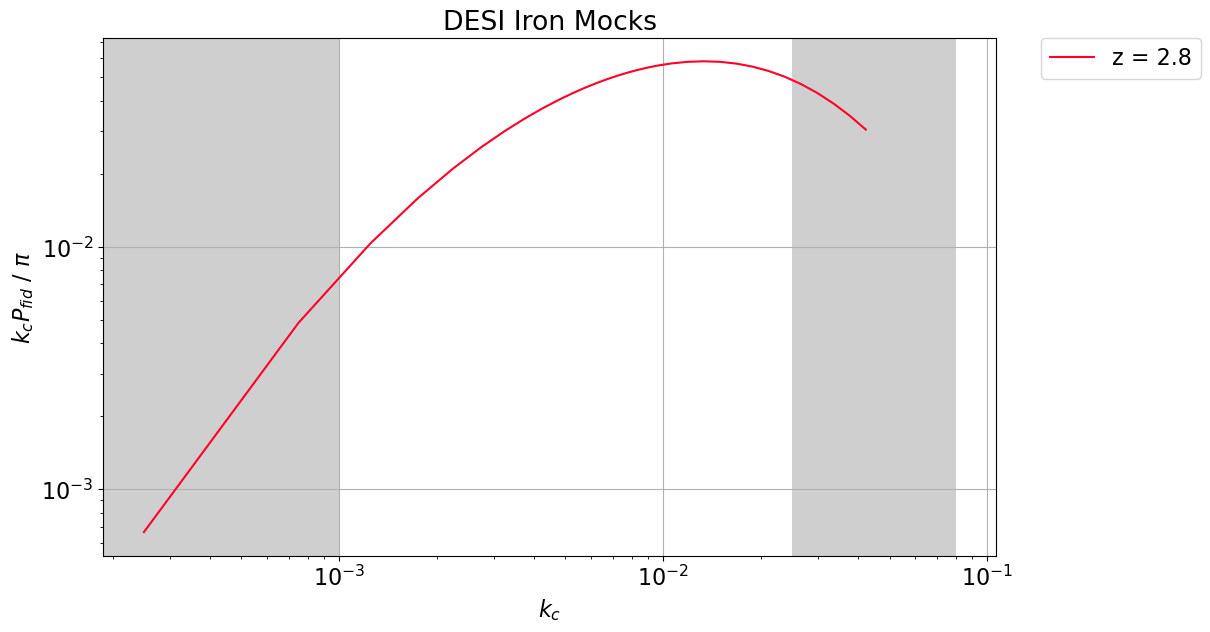

In [115]:
##########################################################################################################################
# USING MOCK ONLY for ALL redshifts
##########################################################################################################################

# for i in [2.0, 2.2, 2.4, 2.6, 2.8, 3.0, 3.2, 3.4, 3.6, 3.8, 4.0, 4.2]:    
for i in [2.8]:
    zmask2 = data2['z'] == i
    plt.plot(data2['kc'][zmask2], np.multiply(data2['kc'][zmask2],data2['Pfid'][zmask2])/np.pi, label = 'z = ' + str(i)) 

    plt.tight_layout()
    plt.xlabel("$k_c$")
    plt.ylabel("$k_c$$P_{fid}$ / $\pi$")
    plt.xscale("log")
    plt.yscale("log")
    plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0)
    plt.grid()
    plt.title('DESI Iron Mocks' )
    
    x1 = 0.025
    x2 = 0.08
    plt.axvspan(x1, x2, color='silver', alpha=0.75, lw=0)
    x3 = 0.000
    x4 = 0.001
    plt.axvspan(x3, x4, color='silver', alpha=0.75, lw=0)
    
    # plt.ylim([-1.5, 1.5])
    # plt.xlim([0.0005, 0.045])

    #plt.show()

##########################################################################################################################
##########################################################################################################################

/tmp/ipykernel_905909/3755152483.py:26: UserWarning: Attempt to set non-positive ylim on a log-scaled axis will be ignored.
  plt.ylim([-1.5, 1.5])


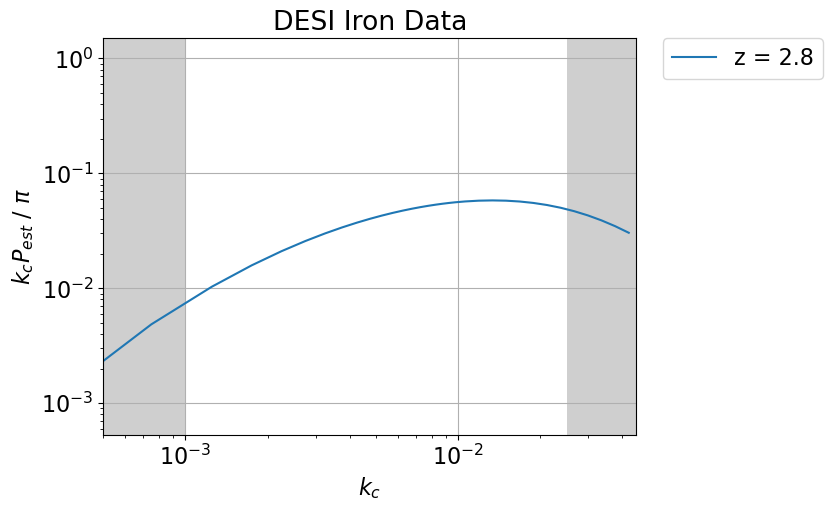

In [118]:
##########################################################################################################################
# USING Data ONLY for ALL redshifts
##########################################################################################################################

# for i in [2.0, 2.2, 2.4, 2.6, 2.8, 3.0, 3.2, 3.4, 3.6, 3.8, 4.0, 4.2]:    
for i in [2.8]:
    zmask1 = data1['z'] == i
    plt.plot(data1['kc'][zmask1], np.multiply(data1['kc'][zmask1],data1['Pfid'][zmask1])/np.pi, label = 'z = ' + str(i)) 

    plt.tight_layout()
    plt.xlabel("$k_c$")
    plt.ylabel("$k_c$$P_{est}$ / $\pi$")
    plt.xscale("log")
    plt.yscale("log")
    plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0)
    plt.grid()
    plt.title('DESI Iron Data' )
    
    x1 = 0.025
    x2 = 0.08
    plt.axvspan(x1, x2, color='silver', alpha=0.75, lw=0)
    x3 = 0.000
    x4 = 0.001
    plt.axvspan(x3, x4, color='silver', alpha=0.75, lw=0)
    
    plt.ylim([-1.5, 1.5])
    plt.xlim([0.0005, 0.045])

    #plt.show()

##########################################################################################################################
##########################################################################################################################

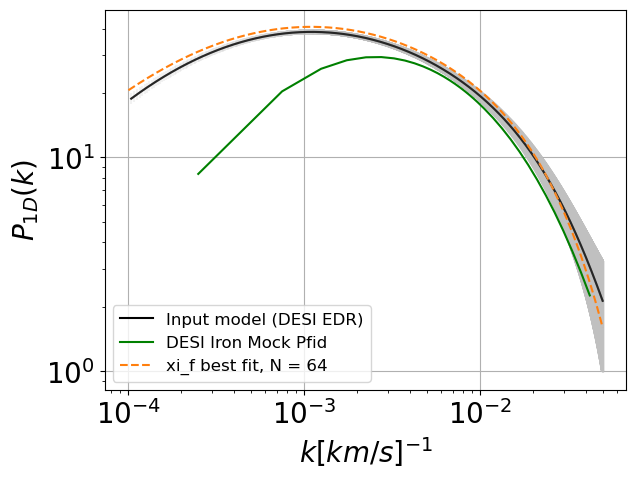

In [153]:
for i in [2.8]:    
    # zmask1 = data1['z'] == i
    # plt.plot(data1['kc'][zmask1], data1['Pfid'][zmask1], 
    #          label = 'DESI Iron Data Pfid', color = 'tab:red', ls='--') 

    plt.errorbar(k_arr[w_k], p1d_edr_fit[redshift_index, w_k], e_p1d[redshift_index], 
                 alpha=0.2, color='silver')
    
    plt.loglog(k_arr[w_k], p1d_edr_fit[redshift_index, w_k], color='black', 
               label=r'Input model (DESI EDR)')

    zmask2 = data2['z'] == i
    plt.plot(data2['kc'][zmask2], data2['Pfid'][zmask2], 
             label = 'DESI Iron Mock Pfid', color = 'green') 
    
    plt.loglog(test_fit_k_arr[w_fit_k], test_fit_power[w_fit_k], 
               label = 'xi_f best fit, N = '+str(downsample_size), color='tab:orange', ls='--')

    plt.tight_layout()
    plt.xlabel("$k [km/s]^{-1}$")
    plt.ylabel("$P_{1D}(k)$")
    plt.xscale("log")
    plt.yscale("log")
    # plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0)
    plt.legend(loc='lower left', fontsize=12)
    plt.grid()
    
    # plt.axvspan(0.05, 0.1, alpha=0.2, color='grey')


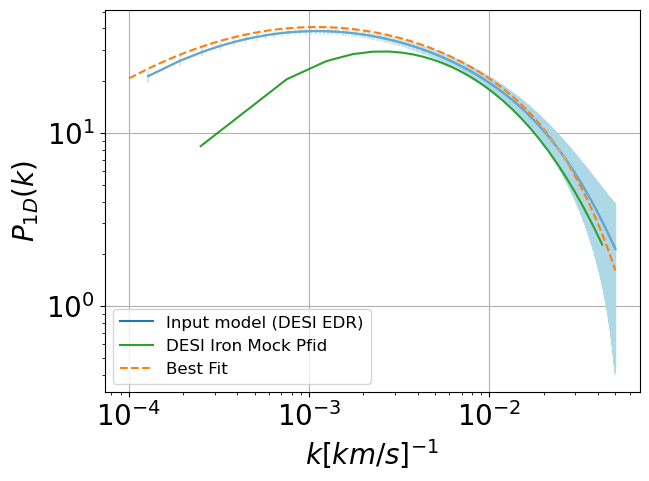

In [176]:
for i in [2.8]:    
    # zmask1 = data1['z'] == i
    # plt.plot(data1['kc'][zmask1], data1['Pfid'][zmask1], 
    #          label = 'DESI Iron Data Pfid', color = 'tab:red', ls='--') 

    plt.errorbar(k_arr[w_k], p1d_edr_fit[redshift_index, w_k], e_p1d[redshift_index], 
                 alpha=0.5, color='lightblue')
    
    plt.plot(k_arr[w_k], p1d_edr_fit[redshift_index, w_k], color='tab:blue', 
               label=r'Input model (DESI EDR)')

    zmask2 = data2['z'] == i
    plt.plot(data2['kc'][zmask2], data2['Pfid'][zmask2], 
             label = 'DESI Iron Mock Pfid', color = 'tab:green') 
    
    plt.plot(test_fit_k_arr[w_fit_k], test_fit_power[w_fit_k], 
               label = 'Best Fit', color='tab:orange', ls='--')

    plt.tight_layout()
    plt.xlabel("$k [km/s]^{-1}$")
    plt.ylabel("$P_{1D}(k)$")
    plt.xscale("log")
    plt.yscale("log")
    # plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0)
    plt.legend(loc='lower left', fontsize=12)
    # plt.legend(loc='upper right', fontsize=12)
    plt.grid()
    
    # plt.axvspan(0.05, 0.1, alpha=0.2, color='grey')
